Ce Notebook présente le développement du Projet 6 - Parcours Data Scientist - OpenClassRooms

# Classifiez automatiquement des biens de consommation

In [1]:
#!pip install flake8
#!pip install pycodestyle
#!pip install pycodestyle_magic
!pip install mglearn
!pip install wordcloud
!pip install opencv-python

!pip install spacy
!pip install Pillow

In [2]:
#%load_ext pycodestyle_magic
#%pycodestyle_on au début du notebook

In [3]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict

In [4]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.collocations import *

#On charge le dictionnaire de stopwords
#disponible dans la librairie nltk
try:
    stopwords = set(stopwords.words('english'))
except LookupError:
    import nltk
    nltk.download('stopwords')
    stopwords = set(stopwords.words('english'))
#stopwords

# Text Mining

In [5]:
data = pd.read_csv("flipkart_com-ecommerce_sample_1050.csv")
data.shape

(1050, 15)

In [6]:
data.head()

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   
3                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4                    False  Key Features of Jaipur Print Cotton Floral Kin...   

        product_rating       overall_rating                  brand  \
0  No rating available  No rating available               Elegance   
1  No rating available  No rating available               Sathiyas   
2  No rating available  No rating available                Eurospa   
3  No rating available  No rating available  SANTOSH ROYAL FASHION   
4  No rating available  No rating available           Jaipur Print   

                              product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "v...  
1  {"product_specification"=>[{"key"=>"Machine Wa...  
2  {"product_specification"=>[{"key"=>"Material",...  
3  {"product_specification"=>[{"key"=>"Brand", "v...  
4  {"product_specification"=>[{"key"=>"Machine Wa...

## Analyse données textes

### Analyse des données brutes

In [7]:
data["product_specifications"][0]

'{"product_specification"=>[{"key"=>"Brand", "value"=>"Elegance"}, {"key"=>"Designed For", "value"=>"Door"}, {"key"=>"Type", "value"=>"Eyelet"}, {"key"=>"Model Name", "value"=>"Abstract Polyester Door Curtain Set Of 2"}, {"key"=>"Model ID", "value"=>"Duster25"}, {"key"=>"Color", "value"=>"Multicolor"}, {"key"=>"Length", "value"=>"213 cm"}, {"key"=>"Number of Contents in Sales Package", "value"=>"Pack of 2"}, {"key"=>"Sales Package", "value"=>"2 Curtains"}, {"key"=>"Material", "value"=>"Polyester"}]}'

In [8]:
data["description"][0]

'Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you

In [9]:
data["product_category_tree"][0]

'["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]'

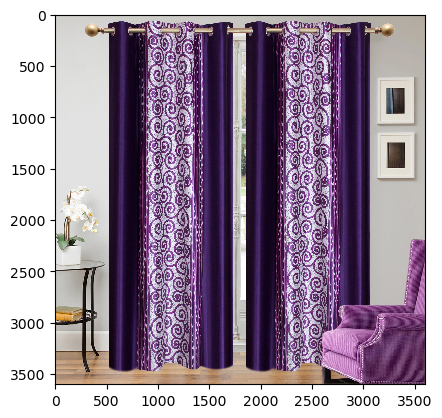

In [10]:
plt.style.use('default')
image = plt.imread("Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg")
plt.imshow(image)

### Récupération catégories de produits

Nous allons commencer par créer un dataset avec uniquement les features qui nous intéresse pour ce projet, et ensuite analyser l'arbre de chaque catégorie de produits de notre jeu de données pour en extraire les sous-catégories.

In [11]:
df_train = data.loc[:, ["description", "product_category_tree"]]

# On crée une liste de strings en supprimant les >>
df = df_train["product_category_tree"].str.split(">>")

# Et on ne récupère que la deuxième valeur de la liste
# Ce qui correspondra à notre catégorie de produits
df_train["sous_cat_1"] = df.apply(lambda x: x[0])
df_train["sous_cat_2"] = df.apply(lambda x: x[1])


In [12]:
print(df[0])

['["Home Furnishing ', ' Curtains & Accessories ', ' Curtains ', ' Elegance Polyester Multicolor Abstract Eyelet Do..."]']


In [13]:
print("Il y a {} produits dans la sous-catégorie 1.".format(len(df_train["sous_cat_1"].unique())))
print("Il y a {} produits dans la sous-catégorie 2.".format(len(df_train["sous_cat_2"].unique())))

Il y a 7 produits dans la sous-catégorie 1.
Il y a 63 produits dans la sous-catégorie 2.


### Nombre de produits dans chaque sous-catégories

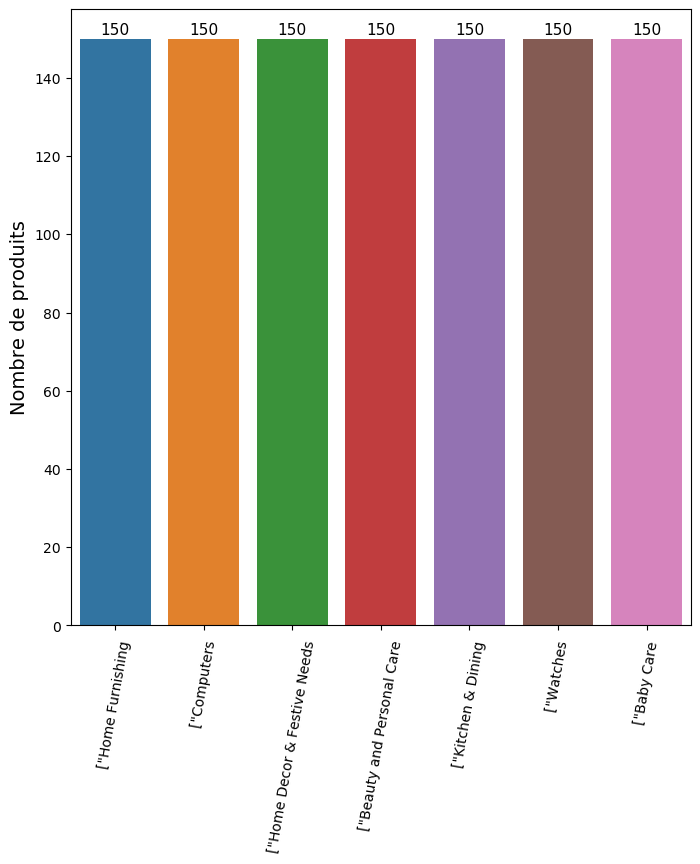

In [14]:
# On commence par faire le comptage de la sous catégorie 1
plt.figure(figsize=(8, 8))
    
plt.xticks(rotation=80)

val = df_train["sous_cat_1"].value_counts()
val = pd.DataFrame(val)

sns.barplot(x=val.index, y=val["sous_cat_1"])

plt.ylabel("Nombre de produits", size=14)

for i, v in enumerate(val["sous_cat_1"].values):
    plt.text(i, v+1, v, color='black', ha='center', size=11)


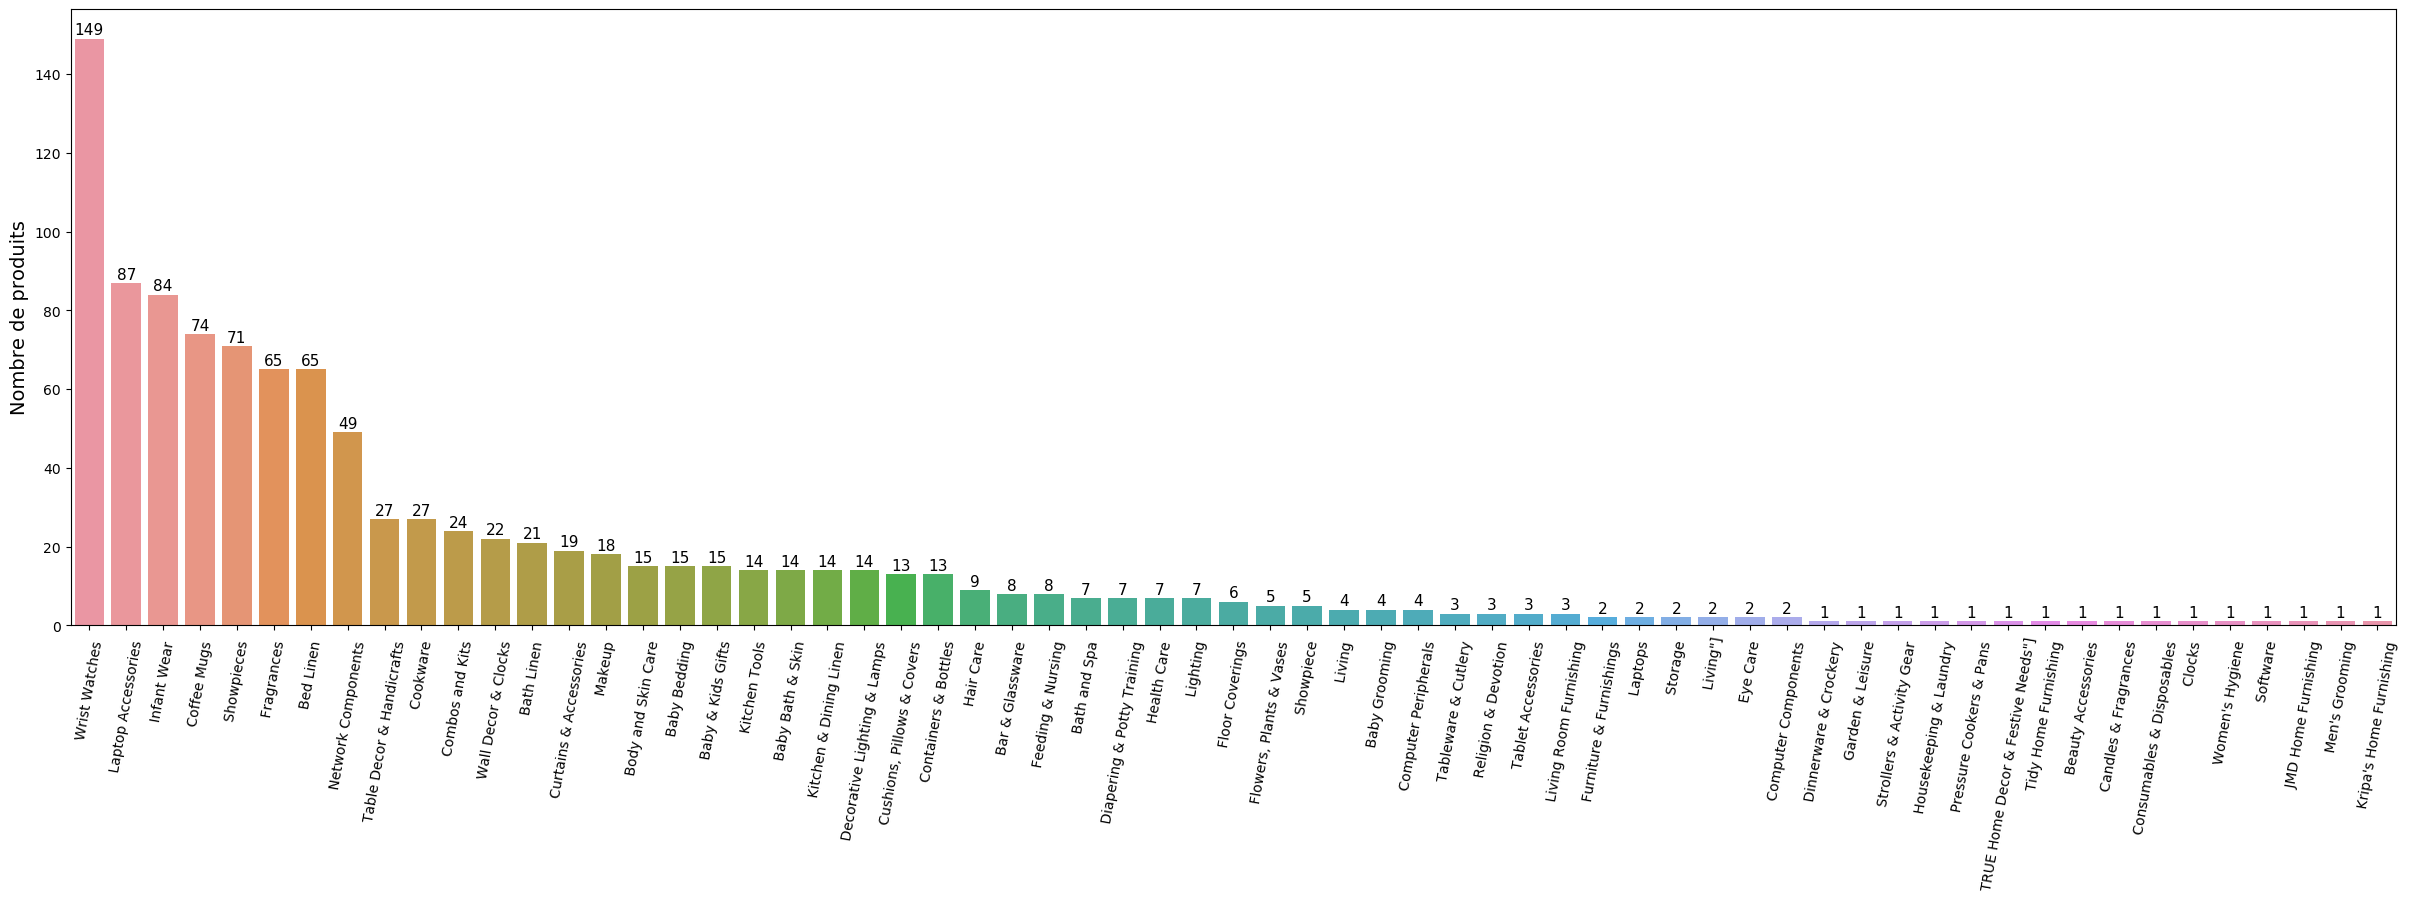

In [15]:
# On commence par faire le comptage de la sous catégorie 1
plt.figure(figsize=(30, 8))
    
plt.xticks(rotation=80)

val = df_train["sous_cat_2"].value_counts()
val = pd.DataFrame(val)

sns.barplot(x=val.index, y=val["sous_cat_2"])

plt.ylabel("Nombre de produits", size=14)

for i, v in enumerate(val["sous_cat_2"].values):
    plt.text(i, v+1, v, color='black', ha='center', size=11)


### Représentations des descriptions

Nous allons représenter les mots les plus fréquemment utilisés dans la totalité des descriptions de notre jeu de données. Sous la forme d'un nuage de mots.

In [16]:
import nltk

from nltk.tokenize import RegexpTokenizer

# Combine all training text into one large string
all_des = ' '.join([text for text in df_train["description"]])

# Ce tokenizer ne capture que les mots capitalisés
capword_tokenizer = RegexpTokenizer("[A-Z]\w+")
all_des_tokened = capword_tokenizer.tokenize(all_des)

display("Nombre de mots au total dans les descriptions:", len(all_des_tokened))

'Nombre de mots au total dans les descriptions:'

41803

(-0.5, 799.5, 499.5, -0.5)

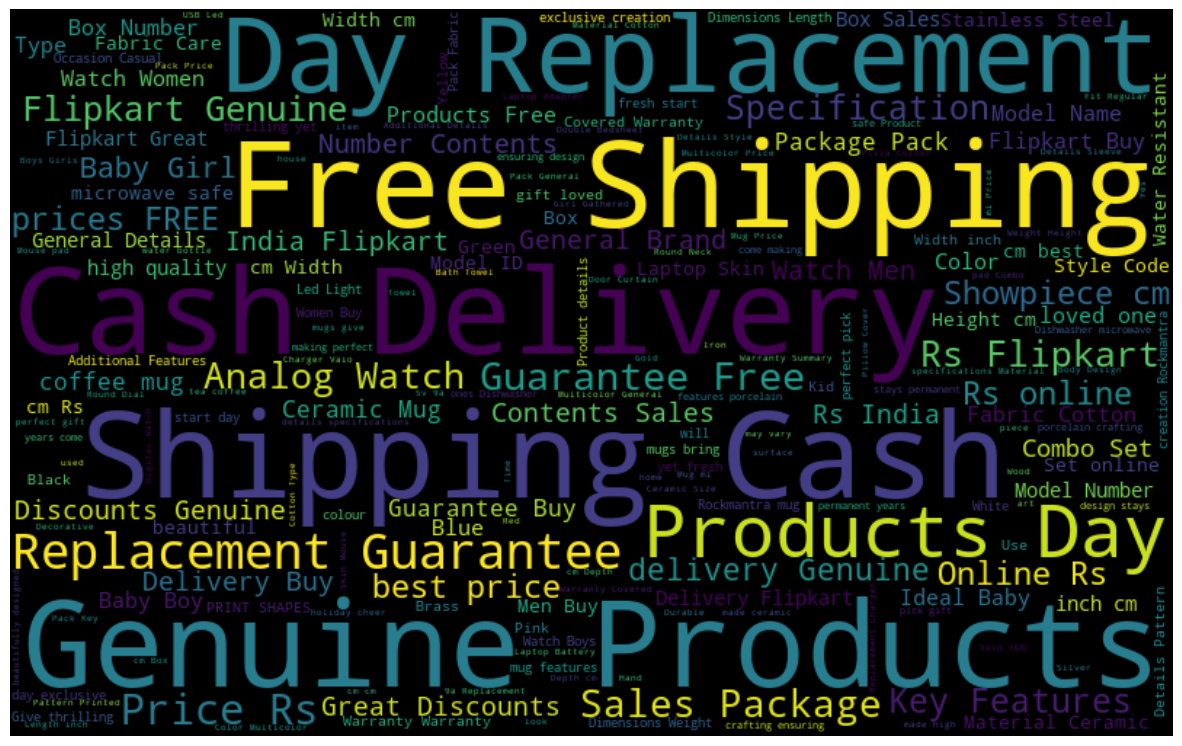

In [17]:
from wordcloud import WordCloud
# Word cloud for entire training dataset
# default width=400, height=200

wordcloud = WordCloud(width=800, height=500,
                      random_state=21, max_font_size=110).generate(all_des)
plt.figure(figsize=(15, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')

Nous allons maintenant représenter sous la forme d'un histogramme les mots les plus fréquemment utilisés dans la catégorie la plus fournie en produits, "Wrist Watches". En repartant de notre tokenisation de mots capitalisés.

In [18]:
df_train["sous_cat_2"] = df_train["sous_cat_2"].str.strip()
des = df_train[df_train["sous_cat_2"] == "Wrist Watches"]

# On récupère toutes les descriptions de la catégorie
# On en forme une chaîne de caractères
des_text = ' '.join(text for text in des["description"])

# On fait une tokenisation de cete chaine
# avec le tokenizer construit précédemment
# On ne garde que les mots capitalisés
des_text_tokenized = capword_tokenizer.tokenize(des_text)

# On recrée une chaîne "propre"
des_text_tokenized = ' '.join(des_text_tokenized)

Text(0.5, 1.0, 'Mots les plus communs dans la catégorie la plus fournie')

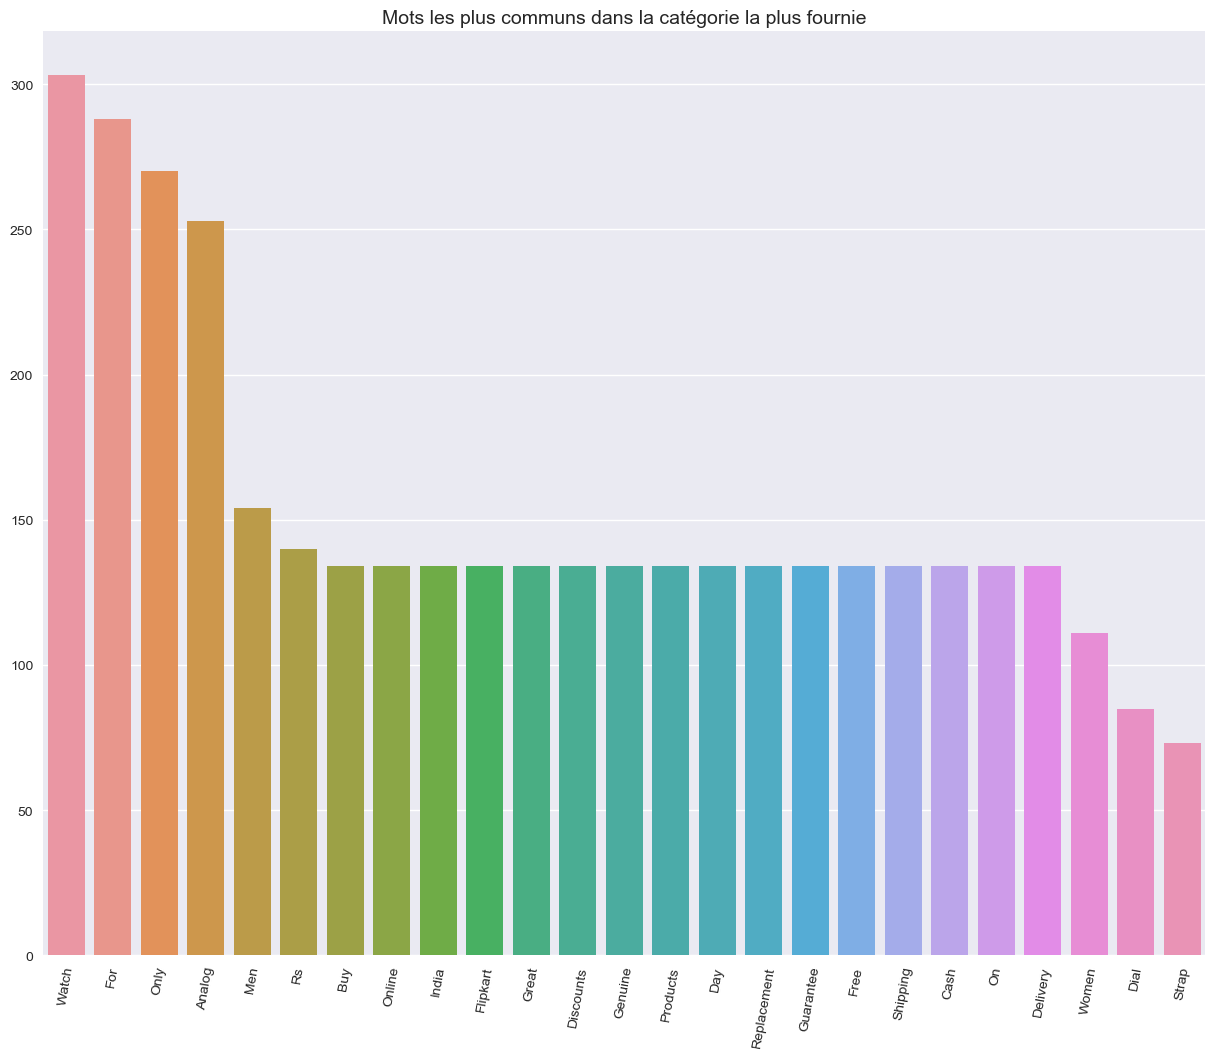

In [19]:
from collections import Counter

des_list = des_text_tokenized.split()
des_counts = Counter(des_list)
des_common_words = [word[0] for word in des_counts.most_common(25)]
des_common_counts = [word[1] for word in des_counts.most_common(25)]

plt.style.use('seaborn')
plt.figure(figsize=(15, 12))
plt.xticks(rotation=80)
sns.barplot(x=des_common_words, y=des_common_counts)
plt.title("Mots les plus communs dans la catégorie la plus fournie", size=14)

### Création de datasets d'apprentissages

des_train = serie comportant les descriptions

des_target = serie comportant les catégories de produits

In [20]:
def clean_sous_cat_1(text):
    text = text[2:]
    return text

In [21]:
des_train = df_train["description"]
des_target = df_train["sous_cat_1"]

#On nettoie le nom des catégories
des_target = des_target.apply(clean_sous_cat_1)

print(des_train[:5])
print("------------------------")
print(des_target[:5])

0    Key Features of Elegance Polyester Multicolor ...
1    Specifications of Sathiyas Cotton Bath Towel (...
2    Key Features of Eurospa Cotton Terry Face Towe...
3    Key Features of SANTOSH ROYAL FASHION Cotton P...
4    Key Features of Jaipur Print Cotton Floral Kin...
Name: description, dtype: object
------------------------
0    Home Furnishing 
1          Baby Care 
2          Baby Care 
3    Home Furnishing 
4    Home Furnishing 
Name: sous_cat_1, dtype: object


### Nettoyage de texte

Avant de commencer l'extraction des mots, nous allons nettoyer le texte de toute ponctuation et majuscules.

In [22]:
def clean_description(description):
    
    # Ce tokenizer ne capture que les mots capitalisés
    capword_tokenizer = RegexpTokenizer("[A-Z]\w+")
    des_tokenized = capword_tokenizer.tokenize(description)
    
    # On recrée une chaîne "propre"
    des_tokenized = ' '.join(des_tokenized)
    
    return des_tokenized.lower()

In [23]:
des_train = des_train.apply(clean_description)
des_train[:5]

0    key features elegance polyester multicolor abs...
1    specifications sathiyas cotton bath towel bath...
2    key features eurospa cotton terry face towel s...
3    key features santosh royal fashion cotton prin...
4    key features jaipur print cotton floral king d...
Name: description, dtype: object

## Bag of Words

Représentation des données textuelles sous forme de sacs de mots.

La représentation par sac de mots est placée dans une matrice creuse Scipy qui n'enregistre que les entrées non nulles. On utilise une matrice creuse, car la plupart des documents ne contiendront qu'un petit sous-ensemble des mots du vocabulaire, ce qui implique que l'essentiel des colonnes sera nul.
Stocker tous ces zéros serait prohibitif et un immense gaspillage de mémoire. Pour observer le contenu réel de la matrice creuse, nous pouvons le convertir en tableau Numpy "dense" (qui va donc aussi contenir toutes les entrées nulles) à l'aide de la méthode toarray.

La fonction CountVectorizer de scikit learn permet d'extraire les mots d'un texte. <b><u>Par défaut cette fonction supprime la ponctuation et passe le texte en minuscules.</u></b>

In [24]:
def extract_mots(data, min_df, stopwords):
    
    vect = CountVectorizer(min_df=min_df, stop_words=stopwords).fit(data)
    X_train = vect.transform(data)
    
    return [vect, X_train]

In [25]:
def check_vocabulaire(vect):
    
    feature_names = vect.get_feature_names()
    print("Nombre de features :", len(feature_names))
    print("20 premières features :", feature_names[:20])
    print("20 dernières features :", feature_names[-20:])

In [26]:
def calcul_performance(X_train, des_target):
    
    param_dist = {'C': [0.001, 0.01, 0.1, 1, 10]}
    random_search = RandomizedSearchCV(LogisticRegression(),
                            param_distributions=param_dist,
                            cv=2,
                            iid=False)

    random_search.fit(X_train, des_target)
    
    return random_search

In [27]:
from sklearn.feature_extraction.text import CountVectorizer

vect, X_train = extract_mots(des_train, 0, [])
print("X_train:\n", format(repr(X_train)))

X_train:
 <1050x3777 sparse matrix of type '<class 'numpy.int64'>'
	with 27754 stored elements in Compressed Sparse Row format>


La taille de X_train, la représentation par sac de mots des données d'apprentissage, est de 1050x6053, ce qui indique que le vocabulaire contient 6053 entrées. A nouveau, les données sont enregistrées sous forme d'une matrice creuse SciPy. Regardons d'un peu plus près ce vocabulaire. Une autre manière d'y accéder consiste à utiliser la méthode get_feature_name du <i>vectorizer</i>, qui retourne une liste dans laquelle chaque entrée correspond à une caractéristique.

In [28]:
check_vocabulaire(vect)

Nombre de features : 3777
20 premières features : ['a200', 'a37', 'a5', 'a55', 'a6', 'aa', 'aaa', 'aapno', 'aari', 'aarika', 'abkl_grn_grn_grn', 'abkl_pl_pl_pnk', 'abkl_pl_pnk_pnk', 'about', 'absorbent', 'absorber', 'abstract', 'abstracts', 'abstrcts', 'ac']
20 dernières features : ['ym22', 'york', 'you', 'young', 'your', 'yourself', 'youth', 'youthful', 'yuva', 'yves', 'zaicus', 'zero', 'zikrak', 'zingalalaa', 'zip', 'zipper', 'zone', 'zoom', 'zora', 'zyxel']


On peut constater  que nous avons des formes au singulier et au pluriel ou des verbes conjugués par exemple. Or ces formes sont évidemment très proches sur le plan sémantique, et les compter en tant que termes différents dans le vocabulaire, et donc en tant que caractéristiques différentes, n'est certainement pas idéal.

Avant d'améliorer notre extraction de caractéristique, nous allons chercher une mesure quantitative des performances en constuisant un classifieur. Les étiquettes de données d'apprentissage sont enregistrées dans des_target et la représentation par sac de mots des données du jeu d'apprentissage se trouvent dans des_train. Nous sommes dans un schéma classique. Nous allons utiliser une LogisticRegression.

Commençons par évaluer <i>LogisticRegression</i> en utilisant une validation croisée.

#### Calcul performance extraction brute

In [29]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

random_search = calcul_performance(X_train, des_target)

print("Mean Random Search accuracy:", random_search.best_score_)

C:\Users\julie\Anaconda\envs\Projet 6-2\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
C:\Users\julie\Anaconda\envs\Projet 6-2\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\julie\Anaconda\envs\Projet 6-2\lib\site-packages\sklearn\model_selection\_search.py:825: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will 

Mean Random Search accuracy: 0.780952380952381


C:\Users\julie\Anaconda\envs\Projet 6-2\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Nous obtenons un score de validation croisée de 79%. 

Voyons maintenant si nous pouvons améliorer l'extraction des mots. Une manière de réduire le nombre de mots (comme par exemple les fautes d'ortographes) consiste à n'utiliser que des "mots" (ou des <i>tokens</i>) qui apparaissent dans au moins deux documents (ou dans au moins cinq documents, et ainsi de suite). En effet, un mot qui ne figurerait que dans un document à une faible probabilité d'être utile. Nous pouvons définir le nombre minimum de documents requis avec le paramètre min_df.

#### Amélioration de l'extraction des mots

In [30]:
vect, X_train = extract_mots(des_train, 3, [])

print("X_train:\n", format(repr(X_train)))

X_train:
 <1050x1029 sparse matrix of type '<class 'numpy.int64'>'
	with 24503 stored elements in Compressed Sparse Row format>


In [31]:
check_vocabulaire(vect)

Nombre de features : 1029
20 premières features : ['aapno', 'abstract', 'ac', 'accessories', 'adapter', 'adaptor', 'add', 'additional', 'adhesive', 'adidas', 'adjustable', 'aero', 'affordable', 'after', 'age', 'air', 'akup', 'alarm', 'all', 'almond']
20 dernières features : ['wine', 'wireless', 'with', 'women', 'wood', 'wooden', 'working', 'world', 'woven', 'wow', 'wrap', 'wrapper', 'yardley', 'year', 'yellow', 'yes', 'you', 'your', 'yourself', 'zyxel']


En exigeant au moins 3 apparitions de chaque token dans des documents différents, nous diminuons nettement le nombre de caractéristiques (1807), soit environ 5 fois moins de la sortie obtenue précédemment.

Effectuons un nouveau calcul de performances.

#### Calcul performance extraction améliorée

In [32]:
random_search = calcul_performance(X_train, des_target)

print("Mean Random Search accuracy:", random_search.best_score_)

C:\Users\julie\Anaconda\envs\Projet 6-2\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
C:\Users\julie\Anaconda\envs\Projet 6-2\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\julie\Anaconda\envs\Projet 6-2\lib\site-packages\sklearn\model_selection\_search.py:825: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will 

Mean Random Search accuracy: 0.78


Le résultat est resté à 79%, donc inchangé par rapport à ce que nous avons déjà vu. Nous n'avons amélioré que légèrement notre modèle, mais, en revanche,  nous avons moins de fonctionnalités susceptibles de ralentir le traitement, et nous avons aussi éliminé bon nombre de caractéristiques inutiles, ce qui pourrait rendre le modèle plus interprétable.

### Suppression des mots vides (StopWords)

Une autre manière d'éliminer des mots sans intérêt consiste à supprimer ceux qui sont tellement courants qu'ils napportent aucune information utile (par exemple les articles définis). On rencontre principalement deux approches :
 - Utiliser une liste de mots vides spécifiques à un langage
 - Eliminer des mots qui apparaissent trop féquemment
 
En fait, scikit-learn possède une liste de mots vides pour l'anglais dans son module feature_extraction_text. Il existe aussi cette possibilité avec la libririe nltk.

In [33]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

print("Nombre de stopwords :", len(ENGLISH_STOP_WORDS))
print("Tous les 10 stopwords :", list(ENGLISH_STOP_WORDS)[::10])

Nombre de stopwords : 318
Tous les 10 stopwords : ['go', 'five', 'seem', 'something', 'beside', 'and', 'moreover', 'herself', 'least', 'from', 'hereupon', 'could', 'hers', 'put', 'otherwise', 'sometime', 'then', 'seems', 'whether', 'am', 'interest', 'eight', 'upon', 'everywhere', 'less', 'ie', 'become', 'on', 'describe', 'perhaps', 'must', 'in']


Clairement, supprimer les mots vides du vocabulaire ne peut que réduire les caractéristiques de la longueur de la liste, soit ici 318. En revanche cette technique peut conduire à une amélioration des performances.

In [34]:
vect, X_train = extract_mots(des_train, 3, "english")

print("X_train:\n", format(repr(X_train)))

X_train:
 <1050x939 sparse matrix of type '<class 'numpy.int64'>'
	with 21352 stored elements in Compressed Sparse Row format>


Nous avons supprimé 1029-939 = 90 caractéristiques, ce qui signifie que la plupart des mots vides de la liste, mais pas tous, apparaissent dans nos documents.

#### Calcul performance avec suppression des StopWords

In [35]:
random_search = calcul_performance(X_train, des_target)

print("Mean Random Search accuracy:", random_search.best_score_)

C:\Users\julie\Anaconda\envs\Projet 6-2\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Mean Random Search accuracy: 0.7933333333333333


C:\Users\julie\Anaconda\envs\Projet 6-2\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\julie\Anaconda\envs\Projet 6-2\lib\site-packages\sklearn\model_selection\_search.py:825: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Les performances n'ont que peu bougé. Cela est dû à la taille du jeu de données qui n'est pas très grande.

<b>Une autre approche aurait été d'éliminer les mots trop fréquemment utilisés, en utilisant l'option <i>max_df</i> de CountVectorizer.</b>

## Pondérer les données avec tf-idf

Au lieu de rejeter des caractéristiques qui sont considérées comme n'étant as importnates, une autre approche consiste à les pondérer en fonction du niveau d'informations que nous en attendons.

L'intuition formulée par cette méthode est de donner un poids élevé aux termes qui apparaissent souvent dans un document particulier, mais pas dans de nombreux documents du corpus. Si un mot apparaît souvent dans un certain document, donc s'il y a une fréquence élevée, mais très rarement ailleurs, il est probablement très représentatif du contenu de CE document.

scikit-learn implémente la méthode tf-idf dans deux classes :
 - TfidfTransformer, qui prend la matrice creuse produite par CountVectorizer et la transforme
 - TfidfVectorizer, qui prend les données textuelles et effectue l'extraction de la représentation tf-idf.

### Calcul performance avec Tf-idf

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(TfidfVectorizer(min_df=3,
                                     norm=None,
                                     stop_words="english"),
                     LogisticRegression())

param_dist = {"logisticregression__C": [0.01, 0.1, 1, 10, 100]}

random_search = RandomizedSearchCV(pipe,
                            param_distributions=param_dist,
                            cv=5,
                            iid=False)

random_search.fit(des_train, des_target)

print("Mean Random Search accuracy:", random_search.best_score_)

C:\Users\julie\Anaconda\envs\Projet 6-2\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
C:\Users\julie\Anaconda\envs\Projet 6-2\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\julie\Anaconda\envs\Projet 6-2\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTA

Mean Random Search accuracy: 0.8676190476190475


C:\Users\julie\Anaconda\envs\Projet 6-2\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\julie\Anaconda\envs\Projet 6-2\lib\site-packages\sklearn\model_selection\_search.py:825: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
C:\Users\julie\Anaconda\envs\Projet 6-2\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations

Le tf-idf a un impact positif car notre performance passe à 87%.

Nous pouvons aussi inspecter quels mots cette méthode a déterminé comme étant les plus importants. Tf-idf a pour but de trouver des mots qui permettent de distinguer des documents, mais il s'agit d'une technique purement non supervisée. Par conséquent, le terme "importants" n'a pas nécessairement de rapport avec les descriptions par produit, donc celles qui nous intéressent en fait.

### Analyses résultats Tf-idf

In [37]:
vectorizer = random_search.best_estimator_.named_steps["tfidfvectorizer"]
X_train = vectorizer.transform(des_train)

max_value = X_train.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()
feature_names = np.array(vectorizer.get_feature_names())

print("Features avec basse valeur :\n", feature_names[sorted_by_tfidf[:20]])
print("Features avec haute valeur :\n", feature_names[sorted_by_tfidf[-20:]])

Features avec basse valeur :
 ['rs' 'genuine' 'guarantee' 'delivery' 'cash' 'shipping' 'discounts' 'buy'
 'additional' 'id' 'flipkart' 'summary' 'specifications' 'clasp' 'general'
 'buckle' 'comforters' 'bleach' 'wireless' 'lowest']
Features avec haute valeur :
 ['crystal' 'fragrance' 'keyboard' 'artificial' 'battery' 'hair' 'buddha'
 'sofa' 'tree' 'copper' 'bed' 'bonsai' 'ocean' 'pot' 'cutter' 'skin' 'tea'
 'plant' 'pizza' 'bowl']


Les mots avec basse valeur sont :
 - soit très courants dans l'ensemble des documents
 - soit utilisés seulement de manière modérée et uniquement dans de très longs documents
 
De manière intéressante, la plupart des résultats correspondant à une valeur tf-udf élevée identifient en fait des catégories, ou des produits précis. Ces mots fournissent certainement des tas d'informations spécifiques sur les descriptions des produits.

Nous pouvons également trouver les mots qui ont une faible fréquence inverse de document (idf), c'est à dire ceux qui apparaissent fréquemment et sont donc considérés comme étant moins importants. Les valeurs de fréquence inverse de document trouvées sur le jeu d'apprentissage sont mémorisées dans l'attribut idf_.

In [38]:
sorted_by_idf = np.argsort(vectorizer.idf_)

print("Features avec basse valeur idf :\n",
      feature_names[sorted_by_idf[:100]])

Features avec basse valeur idf :
 ['rs' 'free' 'products' 'buy' 'genuine' 'replacement' 'day' 'guarantee'
 'flipkart' 'delivery' 'cash' 'shipping' 'price' 'specifications'
 'general' 'features' 'box' 'type' 'package' 'sales' 'number' 'key' 'pack'
 'brand' 'color' 'material' 'india' 'watch' 'set' 'model' 'dimensions'
 'great' 'contents' 'online' 'ideal' 'discounts' 'analog' 'cotton'
 'showpiece' 'fabric' 'width' 'pattern' 'combo' 'baby' 'design' 'details'
 'height' 'men' 'multicolor' 'care' 'additional' 'weight' 'ceramic'
 'water' 'size' 'women' 'round' 'mug' 'yes' 'length' 'black' 'style'
 'dial' 'strap' 'resistant' 'wash' 'code' 'blue' 'warranty' 'occasion'
 'body' 'product' 'girl' 'id' 'boys' 'depth' 'printed' 'girls' 'usb'
 'laptop' 'single' 'casual' 'double' 'light' 'white' 'sleeve' 'green'
 'steel' 'cover' 'print' 'use' 'case' 'power' 'abstract' 'floral'
 'quality' 'gold' 'machine' 'boy' 'pink']


Certains mots relèvent du champs descriptif d'un produit comme <i>guarantee</i> ou <i>design</i>. On peut constater des mots comme <i>shipping</i> ou <i>prices</i> qui font partis des mots les plus fréquents, donc aussi des moins pertinents selon la mesure tf-idf, même si nous pouvons les considérer comme étant très importnats pour la tâche que nous nous sommes fixée.

## Des sacs avec plusieurs mots (n-grammes)


L'un des principaux désavantages de l'utilisation d'une représentation par sac de mots, c'est que l'ordre de ceux-ci est totalement laissé de de côté. Prenons un petit exemple, cette fois en français, en comparant deux chaînes : "c'est mal, c'est pas bien du tout" et "c'est bien, c'est pas mal du tout". La représentation par sac de mots sera exactement la même, alors que le sens des deux phrases est totalement opposé. Placer "pas" devant un autre mot, même s'il s'agit d'un exemple un peu extrême, montre la façon dont le contexte intervient. Heureusement, il existe une manière de capturer ce contexte dans une représentation par sac de mots qui consiste à prendre en compte non seulement la fréquence d'une certain <i>token</i>, mais aussi celle de paires ou de triplets de <i>tokens</i> qui apparaissent les uns à côté des autres. Les paires de <i>tokens</i> sont parfois appelées des <i>bigrammes</i>, les triplets des <i>trigrammes</i>, et plus largement les séquences de <i>n-tokens</i> sont appelées des <i>n-grammes</i>. Nous pouvons personnaliser le nombre de <i>tokens</i> qui sont considérés comme étant proches en changeant le paramètre ngram_range de CountVectorizer ou de TfidfVectorizer. Le paramètre ngram_range est un tuple qui détermine la longueur minimale et la longueur maximale des séquances de <i>tokens</i> qui sont prises en compte.

Essayons TfidfVectorizer sur notre jeu de données, et trouvons la meilleur valeur possible pour la plage des n-grammes en utilisant une recherche sur grille.

In [39]:
from sklearn.model_selection import GridSearchCV

pipe = make_pipeline(TfidfVectorizer(min_df=3,
                                     norm=None,
                                     stop_words="english"),
                     LogisticRegression())

param_grid = {"logisticregression__C": [0.001, 0.01, 0.1, 1, 10],
             "tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)]}

grid = GridSearchCV(pipe,
                    param_grid,
                    cv=5)

grid.fit(des_train, des_target)

print("Best Cross-validation score:", grid.best_score_)
print("Best parameters:\n", grid.best_params_)

C:\Users\julie\Anaconda\envs\Projet 6-2\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\julie\Anaconda\envs\Projet 6-2\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Best Cross-validation score: 0.8752380952380951
Best parameters:
 {'logisticregression__C': 10, 'tfidfvectorizer__ngram_range': (1, 2)}


C:\Users\julie\Anaconda\envs\Projet 6-2\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Comme on peut le constater, les performances sont équivalentes en ajoutant les bigrammes et trigrammes. Nous pouvons visualiser une carte de chaleur de l'exactitude de la validation croisée sous la forme d'une fonction des paramètres nbgram_range et C.

C:\Users\julie\Anaconda\envs\Projet 6-2\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
C:\Users\julie\Anaconda\envs\Projet 6-2\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


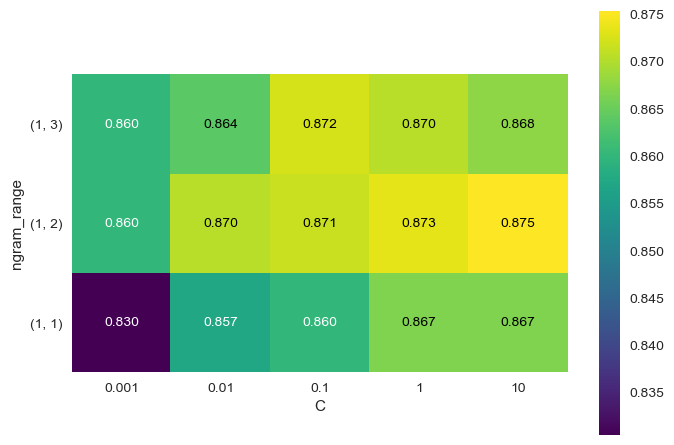

In [40]:
import mglearn

scores = grid.cv_results_["mean_test_score"].reshape(-1, 3).T

heatmap = mglearn.tools.heatmap(scores,
                               xlabel="C",
                               ylabel="ngram_range",
                               cmap="viridis",
                               fmt="%.3f",
                               xticklabels=param_grid["logisticregression__C"],
                               yticklabels=param_grid["tfidfvectorizer__ngram_range"])

plt.colorbar(heatmap)

La carte de chaleur révèle que l'utilisation de bigrammes ou trigrammes n'apporte que peu de différence en termes d'exactitude.

## Tokenisation avancée, racinisation et lemmatisation

L'extraction des caractéristiques par CountVectorizer et TfidfVectorizer est relativement simple, et des méthodes bien plus élaborées sont possibles. Une étape en particulier qui est souvent améliorée dans des applications de fouille de texte plus sophistiquées est la première du modèle de représentation par sac de mots, celle précisément du découpage en "mots", ou <i>tokenisation</i>. Cette étape définit ce qui constitue un mot en vue d'une extraction future.

Nous avons déjà vu que le vocabulaire contient souvent des mots aussi bien au singulier qu'au pluriel. Du point de vue du modèle de représentation par sac de mots, des formes comme par exemple <i>drawing</i> (dessin) et <i>drawings</i> (dessins) sont si proches que les distinguer ne ferait qu'accroître le surapprentissage et ne permettrait pas au modèle d'exploiter pleinement les données d'apprentissage. De même nous avons remarqué des mots qui sont différentes formes verbales et des noms liés aux verbes. Traiter ces variations comme des mots distincts est évidemment désavantageux pour construire un modèle qui se généralise bien.

Ce problème peut être surmonté en représentant chaque mot à partir de sa <i>racine</i> afin de repérer les éléments d'une même "famille". Si cela est réalisé en utilisant une méthode heuristique, éliminant par exemple les préfixes et suffixes courants, on parle de <i>stemming</i> ou <i>racinisation</i>. Si on se sert d'un dictionnaire de formes connues et que le rôle du mot dans la phrase est pris en compte, le processus est appelé <i>lemmatisation</i>, et la forme standardisée, <i>canonique</i>, du mot un <i>lemme</i>. Les deux types de traitement, lemmatisation et racinisation, sont des formes de <i>normalisation</i> qui essaient d'extraire une certaine forme normale à partir d'un mot. Un autre cas intéressant de normalisation du langage est la correction ortographique, domaine fort utile en pratique.

Pour commencer, nous allons comparer une méthode très courante de racinisation (l'algorithme, ou <i>stemmer</i>, de Porter, conçu pour la langue anglaise), avec la lemmatisation.

Nous allons repartir des résultats précédents, c'est-à-dire une optimisation des ngrammes avec un Tf-idf. qui nous donne une performance de 88%.

In [41]:
def lemma_tokenizer(document):
    
    doc_spacy = tokenizer(document)
    
    return [token.lemma_ for token in doc_spacy]

In [42]:
def stemm_tokenizer(document):
    
    doc_spacy = tokenizer(document)
    
    return [stemmer.stem(token.norm_.lower()) for token in doc_spacy]

In [43]:
import nltk

from spacy.lang.en import English

en_nlp = English()
tokenizer = en_nlp.Defaults.create_tokenizer(en_nlp)

lemmer = nltk.stem.WordNetLemmatizer()
stemmer = nltk.stem.PorterStemmer()

des_train = df_train["description"]
des_train = des_train.apply(clean_description)


In [44]:
import re

regexp = re.compile("(?u)\\b\\w\\w+\\b")

old_tokenizer = en_nlp.tokenizer
en_nlp.tokeniser = lambda string: old_tokenizer.tokens_form_list(regexp.findall(string))

lemma_vect = TfidfVectorizer(min_df=3,
                       stop_words="english",
                       decode_error="ignore",
                       ngram_range=(1,2),
                       tokenizer=lemma_tokenizer)

stemm_vect = TfidfVectorizer(min_df=3,
                       stop_words="english",
                       decode_error="ignore",
                       ngram_range=(1,2),
                       tokenizer=stemm_tokenizer)

In [45]:
X_train_lemma = lemma_vect.fit_transform(des_train)
print("Taille vocabulaire après lemmatisation :", X_train_lemma.shape)

X_train_stemm = stemm_vect.fit_transform(des_train)
print("Taille vocabulaire après stemming :", X_train_stemm.shape)

Taille vocabulaire après lemmatisation : (1050, 2371)


C:\Users\julie\Anaconda\envs\Projet 6-2\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop

Taille vocabulaire après stemming : (1050, 2342)


Ces différentes analyses nous montre que la lemmatisation "simplifie" moins le texte que la racinisation puisqu'elle nous ressort plus de mots. Cependant, afin de nous assurer que celle-ci est moins performante que le stemming, nous allons comparer les performances d'une extraction sans tokenisation avancée, puis avec une lemmatisation, et enfin avec du stemming. Cela nous permettra de choisir quelle extraction nous utiliserons pour la suite du projet.

In [46]:
pipe = make_pipeline(TfidfVectorizer(min_df=3,
                                     norm=None,
                                     stop_words="english"),
                     LogisticRegression())

param_grid = {"logisticregression__C": [0.001, 0.01, 0.1, 1, 10],
             "tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)]}

grid = GridSearchCV(pipe,
                    param_grid,
                    cv=5)

grid.fit(des_train, des_target)

print("Best Cross-validation score (tfidfvecorizer sans lemmatisation ou stemming):", grid.best_score_)
print(des_train[:5])

# -----------------------LEMMATISATION---------------------------
pipe = make_pipeline(lemma_vect,
                     LogisticRegression())

param_grid = {"logisticregression__C": [0.001, 0.01, 0.1, 1, 10],
             "tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)]}

grid = GridSearchCV(pipe,
                    param_grid,
                    cv=5)

# On crée une liste avec les descriptions lemmatisées
des_train_lemm = pd.Series()

for doc in des_train:
    doc_spacy = en_nlp(doc)
    des_lemm = ' '.join([token.lemma_ for token in doc_spacy]) 
    des_train_lemm.loc[len(des_train_lemm)] = des_lemm

grid.fit(des_train_lemm, des_target)

print("Best Cross-validation score (Lemmatisation):", grid.best_score_)
print(des_train_lemm[:5])

# -----------------------STEMMING---------------------------

pipe = make_pipeline(stemm_vect,
                     LogisticRegression())

param_grid = {"logisticregression__C": [0.001, 0.01, 0.1, 1, 10],
             "tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)]}

grid = GridSearchCV(pipe,
                    param_grid,
                    cv=5)

# On crée une liste avec les descriptions lemmatisées
des_train_stemm = pd.Series()

for doc in des_train:
    doc_spacy = en_nlp(doc)
    des_stemm = ' '.join([stemmer.stem(token.norm_.lower()) for token in doc_spacy]) 
    des_train_stemm.loc[len(des_train_stemm)] = des_stemm

grid.fit(des_train_stemm, des_target)

print("Best Cross-validation score (Stemming):", grid.best_score_)
print(des_train_stemm[:5])

C:\Users\julie\Anaconda\envs\Projet 6-2\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\julie\Anaconda\envs\Projet 6-2\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Best Cross-validation score (tfidfvecorizer sans lemmatisation ou stemming): 0.8752380952380951
0    key features elegance polyester multicolor abs...
1    specifications sathiyas cotton bath towel bath...
2    key features eurospa cotton terry face towel s...
3    key features santosh royal fashion cotton prin...
4    key features jaipur print cotton floral king d...
Name: description, dtype: object
Best Cross-validation score (Lemmatisation): 0.8723809523809523
0    key features elegance polyester multicolor abs...
1    specifications sathiyas cotton bath towel bath...
2    key features eurospa cotton terry face towel s...
3    key features santosh royal fashion cotton prin...
4    key features jaipur print cotton floral king d...
dtype: object


C:\Users\julie\Anaconda\envs\Projet 6-2\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop

Best Cross-validation score (Stemming): 0.8790476190476191
0    key featur eleg polyest multicolor abstract ey...
1    specif sathiya cotton bath towel bath towel re...
2    key featur eurospa cotton terri face towel set...
3    key featur santosh royal fashion cotton print ...
4    key featur jaipur print cotton floral king dou...
dtype: object


Nous pouvons constater, dans notre cas, que les performances sont assez similaires suivant les trois types de traitements. Cependant, le meilleur score est celui du traitement sans lemmatisation ni stemming. Nous allons choisir comme extraction de texte, la définition suivante :

 - On ne garde que les mots capitalisés
 - On ne garde que les mots apparaissants au moins 3 fois
 - On supprime les stopwords
 - On fait un Tf-idf
 - On utilise des bigrammes

## L'Allocation de Dirichlet latente (LDA)

Intuitivement, le modèle LDAessaie de trouver des groupes de mots (les sujets, ou topics) qui apparaissent fréquemment ensemble. Ce modèle nécessite aussi que chaque document puisse être compris comme un "mélange" d'un sous-ensemble du sujet. Il est indispensable avant tout de bien comprendre que, du point de vue du modèle d'apprentissage automatique, un sujet peut parfaitement être pris pour quelque chose de différent de ce que nous, humains, pourrions appelér ainsi dans la vie quotidienne. En l'occurence, cela ressemble davantage aux composants extraits par les méthodes PCA ou NMF et qui peuvent ou non avoir une signification sémantique. De plus, même s'il existe une telle signification pour un "sujet" LDA, il pourrait ne pas s'agir pour autant de quelque chose que nous appelerions généralement un <i>sujet</i>.

Prenons l'exemple d'articles d'informations quotidiens. Supposons que nous disposons d'une série d'articles concernant le sport, la politique, la finance, mais écrits par deux journalistes différents. Dans un article politique, on peut s'attendre à trouver des mots comm <i>président, vote, parti, etc.</i> De même, dans un article de sport, on peut s'attendre à trouver des mots comme <i>équipe, score, saison, etc.</i> Des mots de chacun de ces groupes devraient probablement apparaître à proximité les uns des autres, tandis que ce genre de rencontre pour les mots <i>président</i> et <i>saison</i> est nettement moins vraisemblable. Cependant, nos deux journalistes peuvent aussi avoir leurs préférences dans la manière de tourner les phrases ou de choisir les mots. Ainsi, l'un d'entre eux pourrait aimer placer dans ses articles le verbe "démarquer", et l'autre le verbe "polariser". Dans ce cas, des sujets <i>autres</i> pourraient être "mots souvent employés par le journaliste A" et "mots souvent employés par le journaliste B", qui ne sont bien sûr pas pour nous des sujets au sens usuel du terme.

Essayons d'appliquer le modèle LDA à notre jeu de données de descriptions de produits afin de voir en pratique coment il fonctionne. Pour ce type de modèle d'apprentissage non supervisé appliqué à des documents textuels, il est souvent bon d'éliminer les mots très courants du fait qu'ils pourraient avoir un poids trop élevé lors de l'analyse. Nous allons reconfigurer nots données avec l'itération expliquée ci-dessus.

In [47]:
vect = TfidfVectorizer(min_df=3,
                norm=None,
                stop_words="english",
                ngram_range=(1,2))

X = vect.fit_transform(des_train)

Nous allons enregistrer les vecteurs que nous a calculé le tf-idf dans notre dataframe.

In [48]:
tfidf_vect = X.toarray().astype("float32")

df_train["tf_idf"] = ""

for i in range(df_train.shape[0]):
    df_train["tf_idf"][i] = tfidf_vect[i]

df_train.head()

description  \
0  Key Features of Elegance Polyester Multicolor ...   
1  Specifications of Sathiyas Cotton Bath Towel (...   
2  Key Features of Eurospa Cotton Terry Face Towe...   
3  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4  Key Features of Jaipur Print Cotton Floral Kin...   

                               product_category_tree          sous_cat_1  \
0  ["Home Furnishing >> Curtains & Accessories >>...  ["Home Furnishing    
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...        ["Baby Care    
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...        ["Baby Care    
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  ["Home Furnishing    
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  ["Home Furnishing    

               sous_cat_2                                             tf_idf  
0  Curtains & Accessories  [0.0, 0.0, 17.279644, 0.0, 0.0, 0.0, 0.0, 0.0,...  
1        Baby Bath & Skin  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2        Baby Bath & Skin  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3               Bed Linen  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
4               Bed Linen  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

Nous allons entraîner un modèle avec 10 sujets, ce qui est suffisamment restreint pour que nous puissions les observer simultanément. De manière semblablel aux composants dans NMF, les sujets n'ont pas d'ordre inhérent, et modifier leur nombre change tous les sujets (en fait, NMF et LDA résolvent des problèmes assez similaires, et nous pourrions aussi nous servir de NMF pour extraire des sujets). Nous utiliserons ici la méthode d'apprentissage "batch", qui est un peu plus lente que la méthode ("online"), mais qui fournit généralement de meilleurs résultats, et nous augmenterons également "max_iter", ce qui peut améliorer les modèles.

In [49]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=7,
                                learning_method="batch",
                                max_iter=25,
                                random_state=0)

document_topics = lda.fit_transform(X)

LatentDirichletAllocation possède un attribut components_ qui mémorise l'importance de chaque mot pour chaque sujet. La taille de components_ est de (n_topics, n_words).

In [50]:
print("lda_components.shape :", lda.components_.shape)

lda_components.shape : (7, 2371)


Pour mieux regarder la signification des différents sujets, nous allons regarder quels sont les mots les plus importants pour chacun d'entre eux. La fonction print_topics permet de présenter clairement ces caractéritiques.

In [51]:
sorting = np.argsort(lda.components_, axis=1)[:,::-1]
feature_names = np.array(vect.get_feature_names())

mglearn.tools.print_topics(topics=range(7),
                          feature_names=feature_names,
                          sorting=sorting,
                          topics_per_chunk=7,
                          n_words=10)

topic 0       topic 1       topic 2       topic 3       topic 4       topic 5       topic 6       
--------      --------      --------      --------      --------      --------      --------      
usb           warranty      flipkart      usb           pack          steel         baby          
dress         ceramic       watch         mugs          features      pizza         details       
light         mug           genuine productssticker       model         maxima        baby girl     
led           rockmantra    genuine       printland     number        strap         girl          
hair          vgn           buy           smart         material      dial          fabric        
gathered      vaio          products      wall          package       stainless     boy           
brass         adapter       free          mug           cover         laptop        baby boy      
led light     product       delivery      happy         width         stainless steelcotton        
power  

On peut constater que les définitions de topics ne sont pas aisées. Puisque nous n'utilisons que 10 sujets, chacun doit représenter un champ très large, de manière à ce qu'ils puissent tous ensembles couvrir la totalité des descriptions de produits de notre jeu de données.

Pour avoir une analyse plus précise, nous devons augmenter le nombre de topics. Essayons donc de couvrir les sous catégories 2 vues précédemment et qui sont au nombre de 63.

In [52]:
import random

n_topics = 63

lda50 = LatentDirichletAllocation(n_components=n_topics,
                                learning_method="batch",
                                max_iter=25,
                                random_state=0)

document_topics50 = lda50.fit_transform(X)

sorting = np.argsort(lda50.components_, axis=1)[:,::-1]
feature_names = np.array(vect.get_feature_names())

# On n'affiche que 10 sujets pris au hasard parmis les 50
mglearn.tools.print_topics(topics=random.sample(range(0, n_topics), 10),
                          feature_names=feature_names,
                          sorting=sorting,
                          topics_per_chunk=5,
                          n_words=10)

topic 1       topic 28      topic 9       topic 4       topic 30      
--------      --------      --------      --------      --------      
fabric        digital       colors        paper         vgn           
kurta         digital watch boys girls    poster        vaio          
details       watch         similar colorspaper print   smartpro      
baby          maxima        similar       polyresin     warranty      
gathered dressdial          wash similar  framed        adapter       
gathered      strap         detergent colorsprint         charger       
baby girl     watch women   colors use    height width  power         
girl          analog        use detergent height        vaio vgn      
dress         men boys      statue        canvas        series vgn    
cotton        lmli          detergent     width         vaio series   


topic 11      topic 52      topic 32      topic 39      topic 40      
--------      --------      --------      --------      --------      
br

Les sujets extraits semblent cette fois être plus spécifiques, quoique nombre d'entres eux soient difficiles à interpréter. Si nous voulons obtenir des inférences supplémentaires en utilisant les sujets que nous venons de découvrir, nous devrions confirmer nos premières intuitions en regardant les mots qui ont obtenu le classement le plus élevé pour chaque sujet, et ce en observant les documents associés à ces sujets. Prenons par exemple le sujet 17. La première intuition est évidemment qu'il concerne le materiel informatique et téléphonie mobile. Regardons alors quelles types de descriptions sont assignées à ce sujet.

In [53]:
informatique = np.argsort(document_topics50[:, 17])[::-1]
print("Nombre de descriptions assignées au sujet :", 17)
for i in informatique[:10]:
    print(df_train.loc[i, "description"])
    print(df_train.loc[i, "description"] + ".\n")


Nombre de descriptions assignées au sujet : 17
Key Features of PRINT SHAPES Graphic Dancer Laptop Skin with Mouse pad Combo Set Glue Free Removal 15.6 inches Laptop skin Easy to Apply & Scratch Resistant Lamination,PRINT SHAPES Graphic Dancer Laptop Skin with Mouse pad Combo Set (Multicolor) Price: Rs. 329 Print Shapes Laptop skin made on High Quality vinyl sheet is compatible with laptops screen sizes ranging from 14.1 inches to 15.6 inches. Trimning of the skin would be required as per your laptop size. The skins are easy to install & remove without leaving any gum or residue,Specifications of PRINT SHAPES Graphic Dancer Laptop Skin with Mouse pad Combo Set (Multicolor) General Brand PRINT SHAPES Model Name Graphic Dancer Laptop Skin with Mouse pad Suitable_for All types of Laptop Color Multicolor Warranty Warranty Summary No Warranty In the Box Number of Contents in Sales Package Pack of 2
Key Features of PRINT SHAPES Graphic Dancer Laptop Skin with Mouse pad Combo Set Glue Free Rem

Comme nous pouvons le voir, ce thème couvre une large variété de produitsconcernant l'informatique, allant de PC portable jusqu'aux petits accessoire. Une autre manière intéressante d'inspecter les sujets consiste à observer leurs poids en sommant l'attribut document_topics sur toutes les descriptions. Dans ce qui suit nous nommerons chaque sujet à partir des deux mots les plus courants.

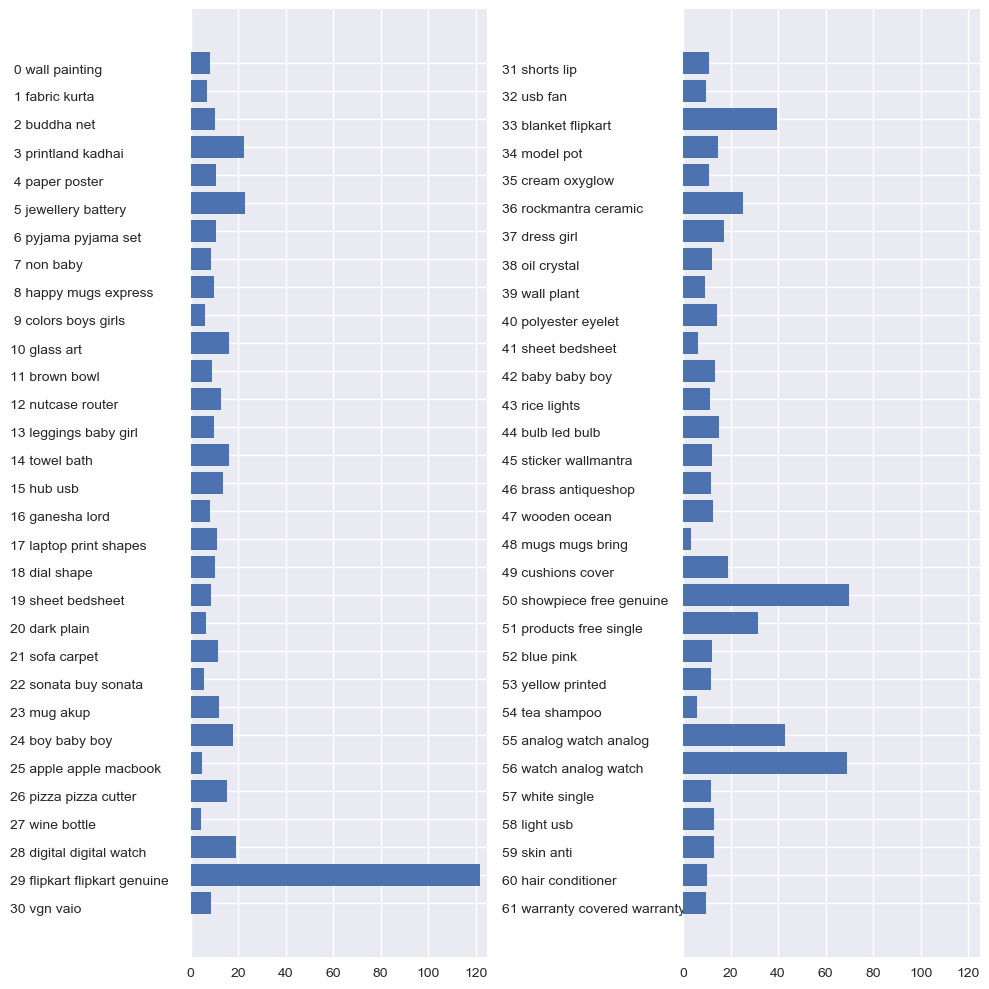

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(10,10))

topic_names = ["{:>2} ".format(i) + " ".join(words) for i, words in enumerate(feature_names[sorting[:, :2]])]

for col in [0, 1]:
    start = col * 31
    end = (col+1) * 31
    ax[col].barh(np.arange(31), np.sum(document_topics50, axis=0)[start:end])
    ax[col].set_yticks(np.arange(31))
    ax[col].set_yticklabels(topic_names[start:end], fontdict={"horizontalalignment":"left", "verticalalignment":"top"})
    ax[col].invert_yaxis()
    ax[col].set_xlim(0,125)
    yax = ax[col].get_yaxis()
    yax.set_tick_params(pad=130)

plt.tight_layout()

### Recherche des topics dominants

Pour classifier l'appartenance d'un document à un topic particulier, une approche logique est de voir quel topic à la contribution la plus grande pour ce document et l'assigner.

Nous allons créer une table où tous les topics majeurs dans un documents ont été passés en vert dans sa propre colonne.

In [55]:
#### Create Document - Topic Matrix
lda_output = lda50.transform(X)

# column names
topicnames = ["Topic" + str(i) for i in range(n_topics)]

# index names
docnames = ["Description" + str(i) for i in range(len(df_train["description"]))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

Regardons la distribution des topics sur l'ensemble de nos descriptions.

In [56]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

Topic Num  Num Documents
0          29            153
1          56             76
2          50             71
3          55             48
4          33             41
..        ...            ...
57         41              5
58          9              4
59         25              4
60         48              3
61         27              2

[62 rows x 2 columns]

In [57]:
print("Mots caractérisant le topic 40:")
mglearn.tools.print_topics(topics=[40],
                          feature_names=feature_names,
                          sorting=sorting,
                          topics_per_chunk=5,
                          n_words=10)
print("Description0 :")
print(df_train["description"][0])

Mots caractérisant le topic 40:
topic 40      
--------      
polyester     
eyelet        
door          
curtain       
aroma comfort 
comfort       
aroma         
door curtain  
curtain height
comfort polyester


Description0 :
Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morni

In [58]:
print("Mots caractérisant le topic 53:")
mglearn.tools.print_topics(topics=[53],
                          feature_names=feature_names,
                          sorting=sorting,
                          topics_per_chunk=5,
                          n_words=10)
print("Description1 :")
print(df_train["description"][1])

Mots caractérisant le topic 53:
topic 53      
--------      
yellow        
printed       
multicolor    
length width  
table         
model         
cover         
seater        
length        
width         


Description1 :
Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Features Machine Washable Yes Material Cotton Design Self Design General Brand Sathiyas Type Bath Towel GSM 500 Model Name Sathiyas cotton bath towel Ideal For Men, Women, Boys, Girls Model ID asvtwl322 Color Red, Yellow, Blue Size Mediam Dimensions Length 30 inch Width 60 inch In the Box Number of Contents in Sales Package 3 Sales Package 3 Bath Towel


## Mise en forme des données

Afin de parvenir à notre clustering, nous devons tout d'abord mettre en forme nos données. Nous allons repartir de nos données originales pour les nettoyées avec une autre méthode. Et pour l'encodage vectoriel, nous allons utiliser <b>Word2Vect</b> afin de <i>parser</i> tous les documents (descriptions). Nous allons donc tranformer les descriptions en vecteurs. Chauque descriptions deviendra un array de float32 de taille 300.

In [59]:
try:
    import spacy
    nlp = spacy.load('en_core_web_sm')
except Exception as e:
    # Un message d'erreur peut apparaître.
    # cymem.cymem.Pool has the wrong size, try recompiling. Expected 64, got 48
    # Sous Windows:
    # pip install http://www.xavierdupre.fr/enseignement/setup/cymem-1.31.2-cp37-cp37m-win_amd64.whl
    # pip install http://www.xavierdupre.fr/enseignement/setup/thinc-6.10.2-cp37-cp37m-win_amd64.whl
    # pip install http://www.xavierdupre.fr/enseignement/setup/spacy-2.0.12-cp37-cp37m-win_amd64.whl
    print(e)

In [60]:
import string

punctuations = string.punctuation

# Define function to cleanup text by removing personal pronouns, stopwords, and puncuation
def cleanup_text(docs, logging=False):
    texts = []
    counter = 1
    for doc in docs:
        if counter % 100 == 0 and logging:
            print("Processed %d out of %d documents." % (counter, len(docs)))
        counter += 1
        doc = nlp(doc, disable=['parser', 'ner'])
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
        tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuations]
        tokens = ' '.join(tokens)
        texts.append(tokens)
        
    return pd.Series(texts)

In [61]:
# Cleanup text and make sure it retains original shape
print('Original training data shape: ', df_train["description"].shape)
train_cleaned = cleanup_text(df_train["description"], logging=True)
print('Cleaned up training data shape: ', train_cleaned.shape)

Original training data shape:  (1050,)
Processed 100 out of 1050 documents.
Processed 200 out of 1050 documents.
Processed 300 out of 1050 documents.
Processed 400 out of 1050 documents.
Processed 500 out of 1050 documents.
Processed 600 out of 1050 documents.
Processed 700 out of 1050 documents.
Processed 800 out of 1050 documents.
Processed 900 out of 1050 documents.
Processed 1000 out of 1050 documents.
Cleaned up training data shape:  (1050,)


In [62]:
train_cleaned.head()

0    key feature elegance polyester multicolor abst...
1    specification sathiyas cotton bath towel 3 bat...
2    key feature eurospa cotton terry face towel se...
3    key feature santosh royal fashion cotton print...
4    key features jaipur print cotton floral king s...
dtype: object

Une fois le texte nettoyé, nous allons faire ce que l'on appelle du <i>parsing</i>, c'est à dire que l'on va parcourir tous les documents pour les mettre en forme avant de les passer dans le modèle de clustering.

In [63]:
from time import time

# Parse documents and print some info
print('Parsing documents...')

start = time()

train_vec = []
for doc in nlp.pipe(train_cleaned, batch_size=500):
    if doc.has_vector:
        train_vec.append(doc.vector)
    # If doc doesn't have a vector, then fill it with zeros.
    else:
        train_vec.append(np.zeros((128,), dtype="float32"))
        
train_vec = np.array(train_vec)

end = time()

Parsing documents...


In [64]:
print('Total time passed parsing documents: {} seconds'.format(end - start))
print('Total number of documents parsed: {}'.format(len(train_vec)))
print('Number of words in first document: ', len(df_train["description"][0]))
print('Number of words in second document: ', len(df_train["description"][1]))
print('Size of vector embeddings: ', train_vec.shape)
print('Shape of vectors embeddings matrix: ', train_vec.shape)

Total time passed parsing documents: 5.234421730041504 seconds
Total number of documents parsed: 1050
Number of words in first document:  1420
Number of words in second document:  444
Size of vector embeddings:  (1050, 96)
Shape of vectors embeddings matrix:  (1050, 96)


In [65]:
all_text = pd.DataFrame(df_train, columns=["description"])

print('Number of total text documents:', len(all_text))

Number of total text documents: 1050


In [66]:
# Define function to preprocess text for a word2vec model
def cleanup_text_word2vec(docs, logging=False):
    
    sentences = []
    counter = 1
    
    for doc in docs:
        
        if counter % 100 == 0 and logging:
            print("Processed %d out of %d documents" % (counter, len(docs)))
            
        # Disable tagger so that lemma_ of personal pronouns (I, me, etc) don't getted marked as "-PRON-"
        doc = nlp(doc, disable=['tagger'])
        # Grab lemmatized form of words and make lowercase
        doc = " ".join([tok.lemma_.lower() for tok in doc])
        # Split into sentences based on punctuation
        doc = re.split("[\.?!;] ", doc)
        # Remove commas, periods, and other punctuation (mostly commas)
        doc = [re.sub("[\.,;:!?]", "", sent) for sent in doc]
        # Split into words
        doc = [sent.split() for sent in doc]
        sentences += doc
        counter += 1
        
    return sentences

In [67]:
%%time

train_cleaned_word2vec = cleanup_text_word2vec(all_text["description"], logging=True)
print('Cleaned up training data size (i.e. number of sentences): ', len(train_cleaned_word2vec))

Processed 100 out of 1050 documents
Processed 200 out of 1050 documents
Processed 300 out of 1050 documents
Processed 400 out of 1050 documents
Processed 500 out of 1050 documents
Processed 600 out of 1050 documents
Processed 700 out of 1050 documents
Processed 800 out of 1050 documents
Processed 900 out of 1050 documents
Processed 1000 out of 1050 documents
Cleaned up training data size (i.e. number of sentences):  5432
Wall time: 8.24 s


Nous devons ensuite indiquer au modèle <b>Word2Vec</b> par combien de vecteurs il faut représenter l'ensemble des mots.

In [68]:
from gensim.models.word2vec import Word2Vec

text_dim = 1000

print("Training Word2Vec model...")

wordvec_model = Word2Vec(train_cleaned_word2vec, size=text_dim, window=5, min_count=3, workers=4, sg=1)

print("Word2Vec model created.")
print("%d unique words represented by %d dimensional vectors" % (len(wordvec_model.wv.vocab), text_dim))

Training Word2Vec model...
Word2Vec model created.
2738 unique words represented by 1000 dimensional vectors


On peut ainsi demander au modèle quels sont les mots les plus similaires à d'autres d'après ces données : par exemple

In [69]:
print(wordvec_model.wv.most_similar(positive=["watch"]))
print(wordvec_model.wv.most_similar(positive=["price"]))

[('analog', 0.9799396395683289), ('digital', 0.9722632765769958), ('sonata', 0.9661773443222046), ('men', 0.9650532603263855), ('maxima', 0.9619307518005371), ('perucci', 0.954820990562439), ('timewel', 0.9523457288742065), ('times', 0.9492425918579102), ('pc-310', 0.9486187696456909), ('decker', 0.947747528553009)]
[('comforters', 0.9263780117034912), ('cream', 0.907670259475708), ('e', 0.8950644135475159), ('lights', 0.8867097496986389), ('wooden', 0.8834834098815918), ('ship', 0.8795211315155029), ('quilts', 0.8790936470031738), ('rice', 0.8784612417221069), ('vanity', 0.871802031993866), ('vitamin', 0.867821455001831)]


In [70]:
# Define function to create word vectors given a cleaned piece of text.
def create_average_vec(doc):
    
    average = np.zeros((text_dim,), dtype='float32')
    num_words = 0.
    
    for word in doc.split():
        if word in wordvec_model.wv.vocab:
            average = np.add(average, wordvec_model[word])
            num_words += 1.
            
    if num_words != 0.:
        average = np.divide(average, num_words)
        
    return average

In [71]:
# Counting the number of empty strings are in train_cleaned
count = 0
for i in range(len(train_cleaned)):
    if train_cleaned[i] == "":
        print("index:", i)
        count += 1
print(count)

0


In [72]:
# Create word vectors
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore", DeprecationWarning)

    train_cleaned_vec = np.zeros((df_train.shape[0], text_dim), dtype="float32")  # 1050 x 300
    
    for i in range(len(train_cleaned)):
        train_cleaned_vec[i] = create_average_vec(train_cleaned[i])

print("Train word vector shape:", train_cleaned_vec.shape)

Train word vector shape: (1050, 1000)


<b><u>On stocke les descriptions encodées dans une variable que l'on réutilisera par la suite pour la clusterisation.</u></b>

In [73]:
des_vectorized = train_cleaned_vec.copy()

In [74]:
df_train["word2vec"] = ""

for i in range(df_train.shape[0]):
    df_train["word2vec"][i] = des_vectorized[i]

In [75]:
df_train.head()

description  \
0  Key Features of Elegance Polyester Multicolor ...   
1  Specifications of Sathiyas Cotton Bath Towel (...   
2  Key Features of Eurospa Cotton Terry Face Towe...   
3  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4  Key Features of Jaipur Print Cotton Floral Kin...   

                               product_category_tree          sous_cat_1  \
0  ["Home Furnishing >> Curtains & Accessories >>...  ["Home Furnishing    
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...        ["Baby Care    
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...        ["Baby Care    
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  ["Home Furnishing    
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  ["Home Furnishing    

               sous_cat_2                                             tf_idf  \
0  Curtains & Accessories  [0.0, 0.0, 17.279644, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1        Baby Bath & Skin  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2        Baby Bath & Skin  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3               Bed Linen  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4               Bed Linen  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                            word2vec  
0  [0.00972075, 0.07499431, 0.002872524, 0.044990...  
1  [-0.001989277, 0.078982145, 0.0034103226, 0.04...  
2  [-0.0033270644, 0.07094201, 0.0076926905, 0.03...  
3  [-0.006638235, 0.076197095, -0.009095058, 0.04...  
4  [-0.0093294075, 0.07681947, -0.005926999, 0.04...

In [76]:
print("Taille vecteur tfidf :", len(df_train["tf_idf"][0]))
print("Taille vecteur word2vec :", len(df_train["word2vec"][0]))

Taille vecteur tfidf : 2371
Taille vecteur word2vec : 1000


# Image processing

### Exploration des images

Dans un premier temps, nous allons analyser le type d'images dont nous disposons (taille - qualité - etc...). Si besoin, nous effectuerons des modifications sur ces images.

Pour la mise en place du CNN, nous avons besoin d'images de dimensions 224x224 en entrée. Nous allons donc redimensionner toutes les images à ce format, afin que cela soit compatible. Et, de ce fait nous pourrons comparer les résultats avec ces nouvelles dimensions d'images de notre segmentation faite avec l'algorithme ORB.

In [77]:
def chemin_complet(image):
    
    # Cette fonction permet de reformater le champs image
    # afin d'avoir le chemin complet dans le but de les
    # charger plus facilement
    
    image = "Images/" + image
    
    return image

In [78]:
# On repart de notre dataframe df_train auquel nous 
# rajoutons les données images
df_train["image"] = data["image"].copy()

# On reformate la colonne image de manière à avoir 
# le chemin complet des fichiers
df_train["image"] = df_train["image"].apply(chemin_complet)

# On reformate la colonne sous_cat_1 pour supprimer
# les deux premiers caractères
df_train["sous_cat_1"] = df_train["sous_cat_1"].apply(clean_sous_cat_1)

df_train.head()

description  \
0  Key Features of Elegance Polyester Multicolor ...   
1  Specifications of Sathiyas Cotton Bath Towel (...   
2  Key Features of Eurospa Cotton Terry Face Towe...   
3  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4  Key Features of Jaipur Print Cotton Floral Kin...   

                               product_category_tree        sous_cat_1  \
0  ["Home Furnishing >> Curtains & Accessories >>...  Home Furnishing    
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...        Baby Care    
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...        Baby Care    
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  Home Furnishing    
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  Home Furnishing    

               sous_cat_2                                             tf_idf  \
0  Curtains & Accessories  [0.0, 0.0, 17.279644, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1        Baby Bath & Skin  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2        Baby Bath & Skin  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3               Bed Linen  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4               Bed Linen  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                            word2vec  \
0  [0.00972075, 0.07499431, 0.002872524, 0.044990...   
1  [-0.001989277, 0.078982145, 0.0034103226, 0.04...   
2  [-0.0033270644, 0.07094201, 0.0076926905, 0.03...   
3  [-0.006638235, 0.076197095, -0.009095058, 0.04...   
4  [-0.0093294075, 0.07681947, -0.005926999, 0.04...   

                                         image  
0  Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg  
1  Images/7b72c92c2f6c40268628ec5f14c6d590.jpg  
2  Images/64d5d4a258243731dc7bbb1eef49ad74.jpg  
3  Images/d4684dcdc759dd9cdf41504698d737d8.jpg  
4  Images/6325b6870c54cd47be6ebfbffa620ec7.jpg

#### Création d'images en niveaux de gris

L'algorithme ORB ne fonctionne qu'avec des images en niveaux de gris. Nous allons donc passer notre jeu d'images en gris ainsi que faire des retouches d'amélioration du bruit et de contraste en normalisant l'histogramme de chaque image.

In [79]:
def transform_grayscale(image):
    
    file_dir=os.path.split(image)
    
    # Conversion en niveau de gris de l'image
    img = Image.open(image).convert("L")
    
    # Egalisation de l'histogramme
    img = ImageOps.equalize(img)
    
    # Suppression du bruit avec un kernel (nombre de pixels) = 3
    img = img.filter(ImageFilter.MedianFilter(size=3))
    
    img.save("Images_grayscale/"+file_dir[1])
    
    return "Images_grayscale/"+file_dir[1]

In [80]:
from PIL import Image, ImageOps, ImageFilter
import os

# On convertit les images en niveaux de gris
df_train["image_grayscale"] = df_train["image"].apply(transform_grayscale)

C:\Users\julie\Anaconda\envs\Projet 6-2\lib\site-packages\PIL\Image.py:2731: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


#### Redimensionnement d'images

Les réseaux neruronaux que nous allons utiliser par la suite acceptent (par défaut) en entrée des images de 224x224. Nous allons donc redimensionner toutes les imagges dans cette dimensions en respectant le ration Hauteur/Largeur. 

In [81]:
def redim_image(image):
    
    # Cette fonction permet de redimensionner une
    # image en tenant compte de ses proportions
    # initiales
    
    # On charge l'image d'origine
    img = Image.open(image)
    file_dir=os.path.split(image)
    
    width, height = img.size
    
    # On test si c'est une image au format
    # paysage ou portrait, ou même carrée
    
    # On récupère le côté le plus grand et on le
    # redimensionne à la taille souhaitée, ici 224.
    # Tout en gardant le ratio hauteur/largeur pour
    # l'autre côté.
    if height > width:
    
        aspect = height / 224
        new_size = (int(width/aspect), 224)
    elif width > height:
        
        aspect = width / 224
        new_size = (224, int(height/aspect))
    else:
        
        new_size = (224, 224)
    
    # On enregistre dans un nouveau dossier l'image redimensionnée.
    img.resize(new_size).save("Images_redim/"+file_dir[1])

    # Nous avons une image de taille 224xXXX ou XXXx224, or
    # notre CNN n'accepte que des images de la taille 224x224,
    # il nous faut donc retravailler la taille de l'image.
    
    # Pour cela, nous allons créer une image de taille 224x224
    # entièrement blanche, puis coller notre image redimensionnée
    # précédemment de manière centrée sur cette image blanche.
    
    img = Image.open("Images_redim/"+file_dir[1])
    
    width, height = img.size
    
    if height > width:
        new_img = Image.new('RGB', (224, 224),(255,255,255)) # white
        
        pos_lrg = int((height - width) / 2)
        new_img.paste(img, box=(pos_lrg,0))
        
        new_img.save("Images_redim/"+file_dir[1])
        
    elif width > height:
        new_img = Image.new('RGB', (224, 224),(255,255,255)) # white
        
        pos_ht = int((width - height) / 2)
        new_img.paste(img, box=(0, pos_ht))

        new_img.save("Images_redim/"+file_dir[1])
    
    
    return "Images_redim/"+file_dir[1]

In [82]:
def redim_test(image):
    
    # Cette fonction sert juste à montrer ce que donne une image
    # redimensionnée sans prendre en compte les proportions.
    # Cele sert juste à illustrer le support de présentation du
    # projet.
    
    img = Image.open(image)
    file_dir=os.path.split(image)
    
    width, height = img.size
    
    new_size = (224, 224)
        
    img.resize(new_size).save("Images_redim_test/"+file_dir[1])
    
    return "Images_redim_test/"+file_dir[1]

In [83]:
def autocontraste(image):
    
    # Cette fonction permet d'ajuster automatiquement le
    # contraste d'une image. 
    
    img = Image.open(image)
        
    dimg = ImageOps.autocontrast(img, cutoff=0.5)
    
    file_dir=os.path.split(image)
    dimg.save("Images_redim_contrast/"+file_dir[1])
    
    return "Images_redim_contrast/"+file_dir[1]

In [84]:
def affich_image(df_images):
    
    fig = plt.figure(figsize=(15, 5))
    
    columns = 5
    rows = 2
    i = 1
    
    for img in df_images["image_redim"]:
        
        plt.style.use('default')
        image = plt.imread(img)
        fig.add_subplot(rows, columns, i)
        plt.imshow(image)
        plt.axis('off')
        i += 1

In [85]:
%%time

# On redimensionne les images en 224x224 brutalement
# Sert uniquement pour le support de présentation
for i in range(0,20):
    redim_test(df_train["image"][i])

# On redimensionne les images en conservant les proportions d'origine
df_train["image_redim"] = df_train["image"].apply(redim_image)

# On redimensionne les images en conservant les proportions d'origine
df_train["image_redim_contrast"] = df_train["image_redim"].apply(autocontraste)

df_train.head()

Wall time: 18.3 s


description  \
0  Key Features of Elegance Polyester Multicolor ...   
1  Specifications of Sathiyas Cotton Bath Towel (...   
2  Key Features of Eurospa Cotton Terry Face Towe...   
3  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4  Key Features of Jaipur Print Cotton Floral Kin...   

                               product_category_tree        sous_cat_1  \
0  ["Home Furnishing >> Curtains & Accessories >>...  Home Furnishing    
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...        Baby Care    
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...        Baby Care    
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  Home Furnishing    
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  Home Furnishing    

               sous_cat_2                                             tf_idf  \
0  Curtains & Accessories  [0.0, 0.0, 17.279644, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1        Baby Bath & Skin  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2        Baby Bath & Skin  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3               Bed Linen  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4               Bed Linen  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                            word2vec  \
0  [0.00972075, 0.07499431, 0.002872524, 0.044990...   
1  [-0.001989277, 0.078982145, 0.0034103226, 0.04...   
2  [-0.0033270644, 0.07094201, 0.0076926905, 0.03...   
3  [-0.006638235, 0.076197095, -0.009095058, 0.04...   
4  [-0.0093294075, 0.07681947, -0.005926999, 0.04...   

                                         image  \
0  Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  Images/7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  Images/64d5d4a258243731dc7bbb1eef49ad74.jpg   
3  Images/d4684dcdc759dd9cdf41504698d737d8.jpg   
4  Images/6325b6870c54cd47be6ebfbffa620ec7.jpg   

                                     image_grayscale  \
0  Images_grayscale/55b85ea15a1536d46b7190ad6fff8...   
1  Images_grayscale/7b72c92c2f6c40268628ec5f14c6d...   
2  Images_grayscale/64d5d4a258243731dc7bbb1eef49a...   
3  Images_grayscale/d4684dcdc759dd9cdf41504698d73...   
4  Images_grayscale/6325b6870c54cd47be6ebfbffa620...   

                                         image_redim  \
0  Images_redim/55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  Images_redim/7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  Images_redim/64d5d4a258243731dc7bbb1eef49ad74.jpg   
3  Images_redim/d4684dcdc759dd9cdf41504698d737d8.jpg   
4  Images_redim/6325b6870c54cd47be6ebfbffa620ec7.jpg   

                                image_redim_contrast  
0  Images_redim_contrast/55b85ea15a1536d46b7190ad...  
1  Images_redim_contrast/7b72c92c2f6c40268628ec5f...  
2  Images_redim_contrast/64d5d4a258243731dc7bbb1e...  
3  Images_redim_contrast/d4684dcdc759dd9cdf415046...  
4  Images_redim_contrast/6325b6870c54cd47be6ebfbf...

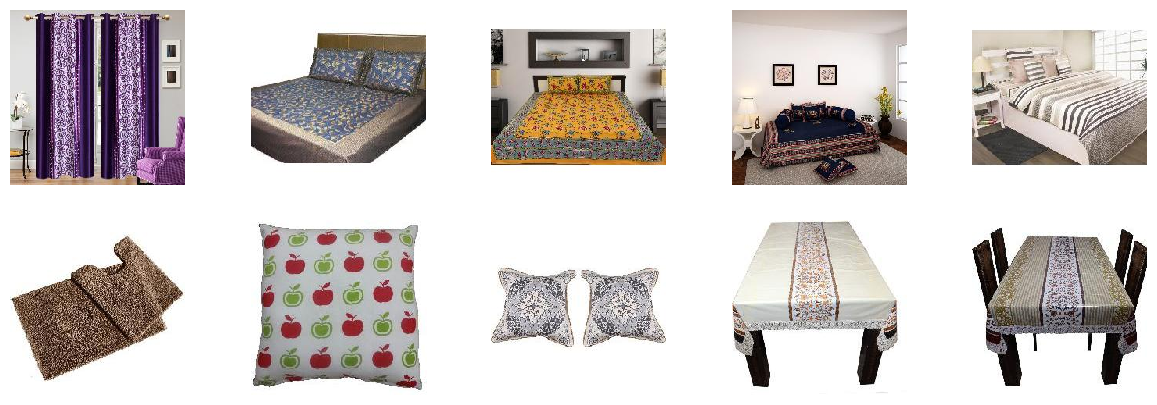

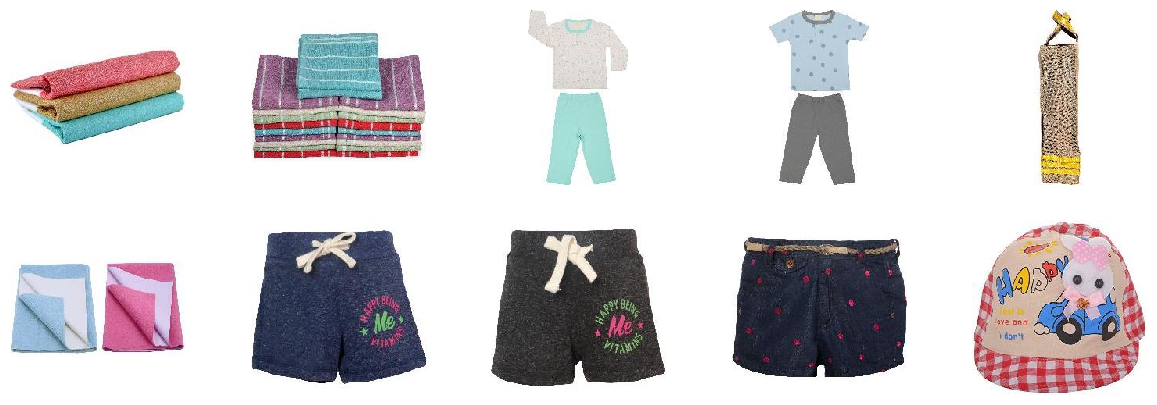

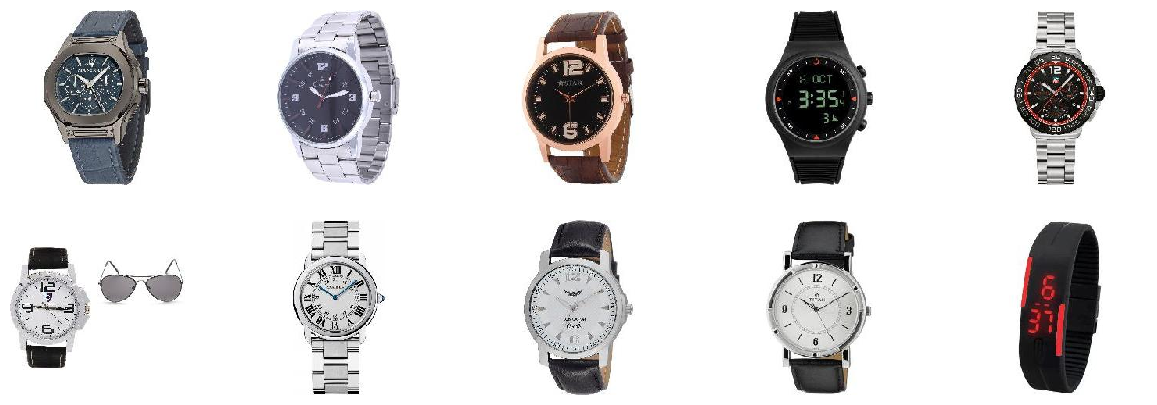

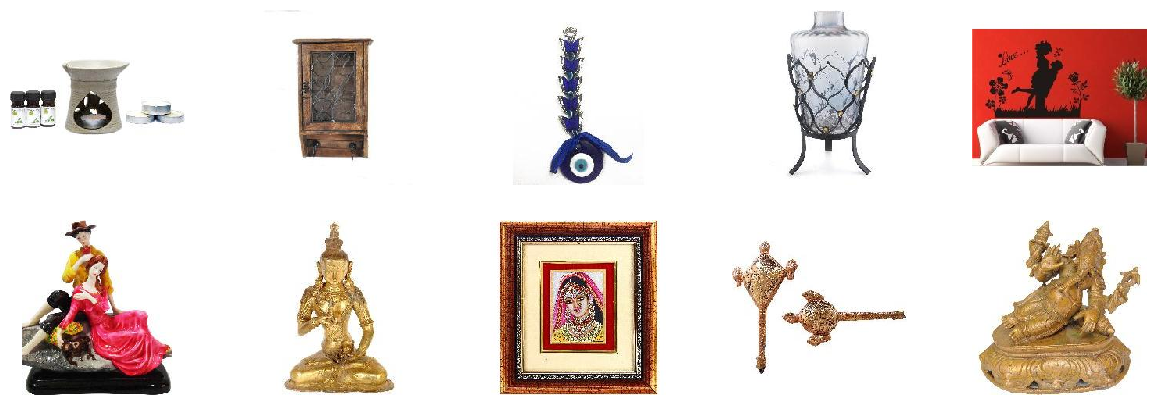

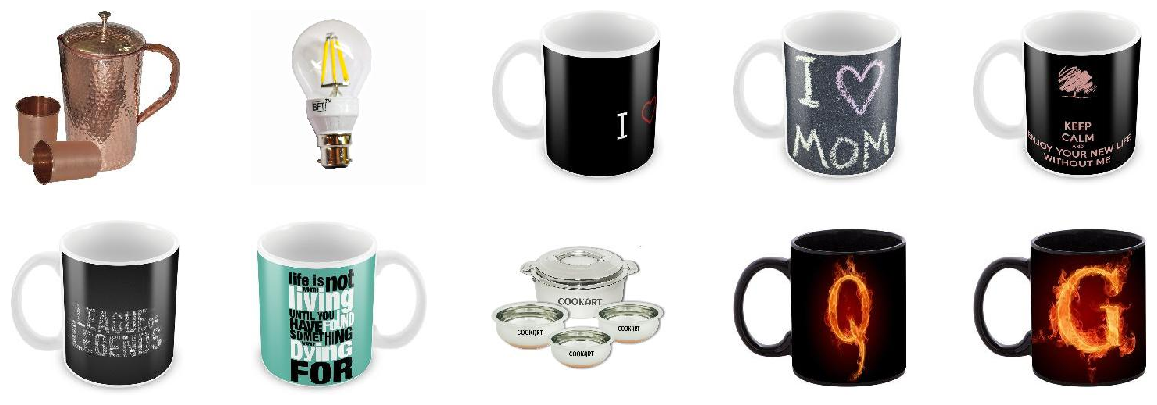

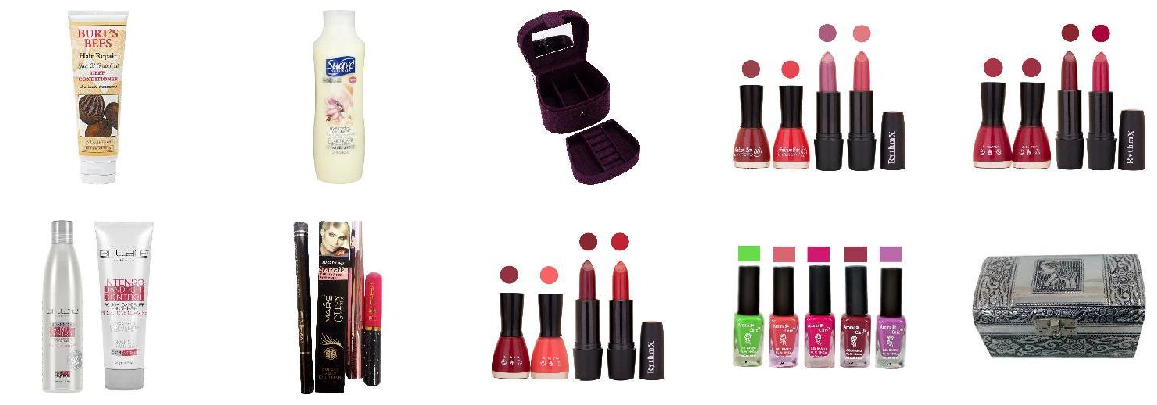

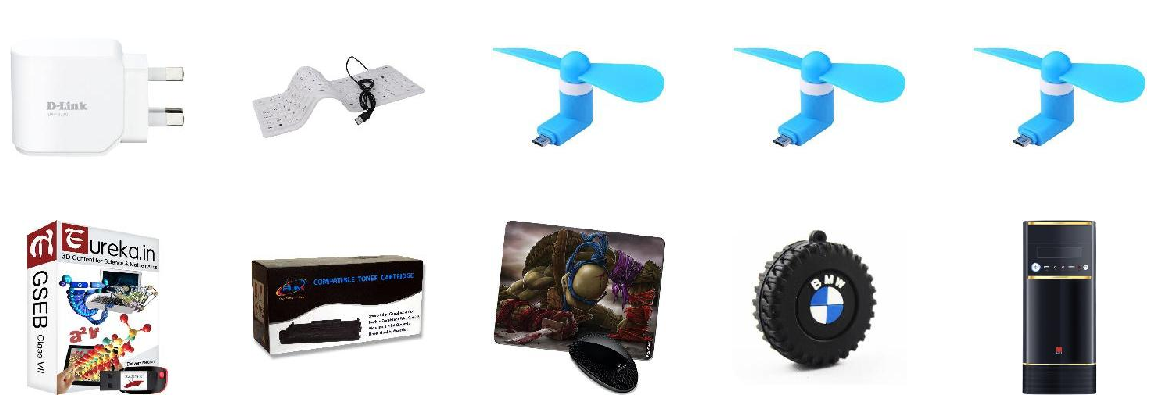

In [86]:
for cat in df_train["sous_cat_1"].unique():
    
    df = df_train.loc[df_train["sous_cat_1"] == cat]
    df = df[:10]
    affich_image(df)

In [87]:
%%time

df = df_train.loc[:, ["sous_cat_1", "image_redim_contrast"]]
df.head()

Wall time: 1e+03 µs


sous_cat_1                               image_redim_contrast
0  Home Furnishing   Images_redim_contrast/55b85ea15a1536d46b7190ad...
1        Baby Care   Images_redim_contrast/7b72c92c2f6c40268628ec5f...
2        Baby Care   Images_redim_contrast/64d5d4a258243731dc7bbb1e...
3  Home Furnishing   Images_redim_contrast/d4684dcdc759dd9cdf415046...
4  Home Furnishing   Images_redim_contrast/6325b6870c54cd47be6ebfbf...

### L'algorithme ORB

Afin de trouver des features qui nous permettrons de comparer des images entre elles, nous allons essayer l'algorithme ORB. C'est une alternative aux algorithmes SIFT et SURF qui à l'avantage d'être gratuit contrairement aux deux autres.

La chose la plus importante à noter est que ces algorithmes de détection de caractéristiques dans opencv nécessitent une image en niveaux de gris à canal unique (typiquement 8 bits).

In [88]:
dictionary_size = 1000
# Loading images
imgs_data = []
# imreads returns a list of all images in that directory
imgs = df_train["image_grayscale"]
for i in range(len(imgs)):
    # create a numpy to hold the histogram for each image
    imgs_data.insert(i, np.zeros((dictionary_size, 1)))

In [89]:
import cv2

def get_descriptors(image, detector):
    
    img = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    kp, des = detector.detectAndCompute(img, None)
    
    # returns descriptors of an image
    return des

# Extracting descriptors
detector = cv2.ORB_create(nfeatures=1500)

desc = np.array([])

# desc_src_img is a list which says which image a descriptor belongs to
desc_src_img = []
for i in range(len(imgs)):
    
    img = imgs[i]
    descriptors = get_descriptors(img, detector)
    
    if len(desc) == 0:
        desc = np.array(descriptors)
    else:
        desc = np.vstack((desc, descriptors))
        
    # Keep track of which image a descriptor belongs to
    for j in range(len(descriptors)):
        desc_src_img.append(i)
        
# important, cv2.kmeans only accepts type32 descriptors
desc = np.float32(desc)

In [90]:
desc.shape

(1517331, 32)

In [91]:
# Clustering
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 0.01)

flags = cv2.KMEANS_PP_CENTERS

# desc is a type32 numpy array of vstacked descriptors
compactness, labels, dictionary = cv2.kmeans(desc, dictionary_size, None, criteria, 1, flags)

Wall time: 1min 29s


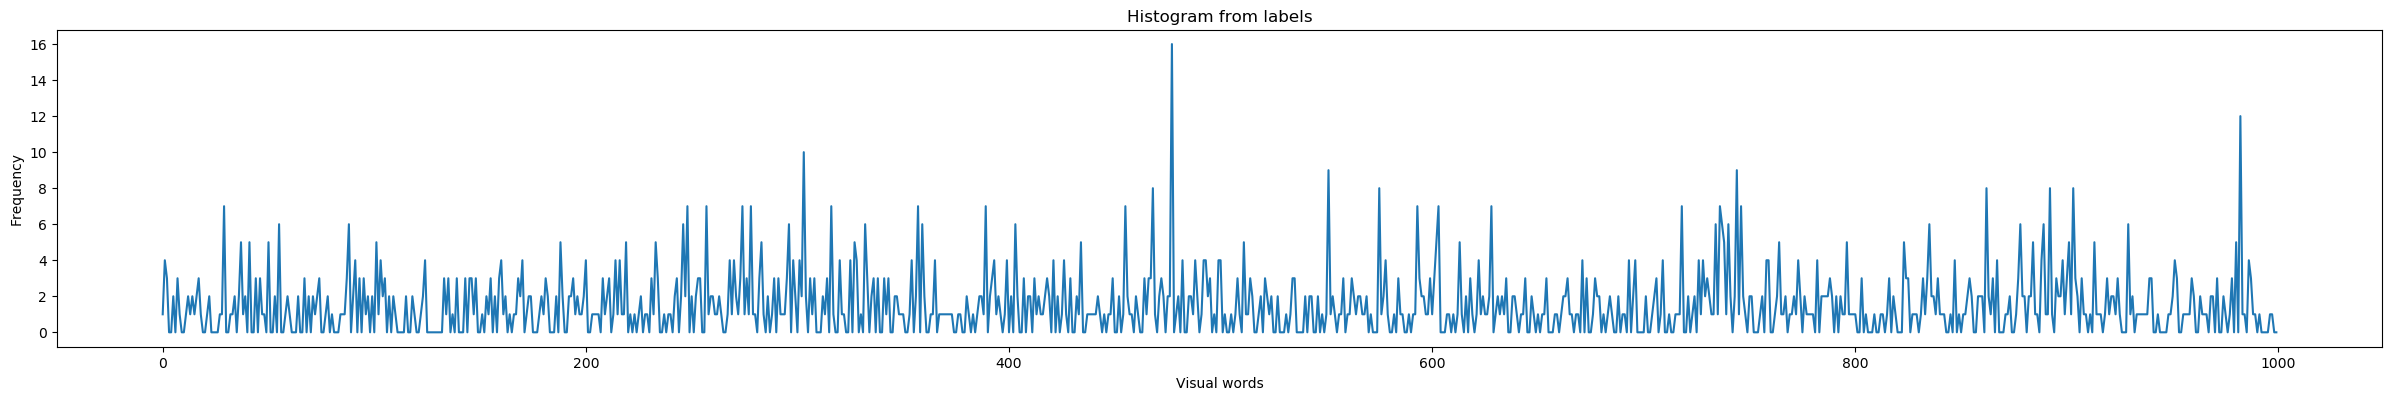

In [92]:
%%time 

# Getting histograms from labels
size = labels.shape[0] * labels.shape[1]

df_train["bovw"] = ""
for i in range(size):
    label = labels[i]
    # Get this descriptors image id
    img_id = desc_src_img[i]
    # imgs_data is a list of the same size as the number of images
    data_img = imgs_data[img_id]
    # data is a numpy array of size (dictionary_size, 1) filled with zeros
    data_img[label] += 1
    df_train["bovw"][img_id] = data_img.flatten()

plt.figure(figsize=(30,14))
ax = plt.subplot(311)
ax.set_title("Histogram from labels")
ax.set_xlabel("Visual words")
ax.set_ylabel("Frequency")
ax.plot(imgs_data[1].ravel())

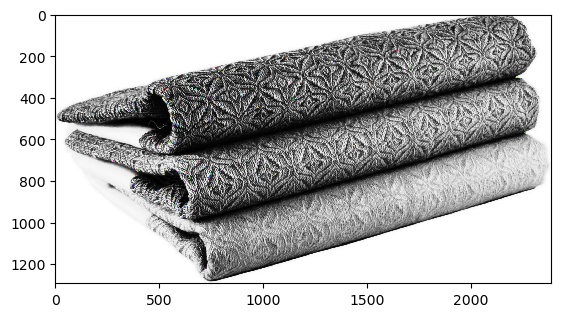

In [93]:
img = df_train["image_grayscale"][1]

orb = cv2.ORB_create()

img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)

keypoints, descriptors = orb.detectAndCompute(img, None)

img = cv2.drawKeypoints(img, keypoints, None)

plt.imshow(img)

In [94]:
df_train.head()

description  \
0  Key Features of Elegance Polyester Multicolor ...   
1  Specifications of Sathiyas Cotton Bath Towel (...   
2  Key Features of Eurospa Cotton Terry Face Towe...   
3  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4  Key Features of Jaipur Print Cotton Floral Kin...   

                               product_category_tree        sous_cat_1  \
0  ["Home Furnishing >> Curtains & Accessories >>...  Home Furnishing    
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...        Baby Care    
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...        Baby Care    
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  Home Furnishing    
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  Home Furnishing    

               sous_cat_2                                             tf_idf  \
0  Curtains & Accessories  [0.0, 0.0, 17.279644, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1        Baby Bath & Skin  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2        Baby Bath & Skin  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3               Bed Linen  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4               Bed Linen  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                            word2vec  \
0  [0.00972075, 0.07499431, 0.002872524, 0.044990...   
1  [-0.001989277, 0.078982145, 0.0034103226, 0.04...   
2  [-0.0033270644, 0.07094201, 0.0076926905, 0.03...   
3  [-0.006638235, 0.076197095, -0.009095058, 0.04...   
4  [-0.0093294075, 0.07681947, -0.005926999, 0.04...   

                                         image  \
0  Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  Images/7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  Images/64d5d4a258243731dc7bbb1eef49ad74.jpg   
3  Images/d4684dcdc759dd9cdf41504698d737d8.jpg   
4  Images/6325b6870c54cd47be6ebfbffa620ec7.jpg   

                                     image_grayscale  \
0  Images_grayscale/55b85ea15a1536d46b7190ad6fff8...   
1  Images_grayscale/7b72c92c2f6c40268628ec5f14c6d...   
2  Images_grayscale/64d5d4a258243731dc7bbb1eef49a...   
3  Images_grayscale/d4684dcdc759dd9cdf41504698d73...   
4  Images_grayscale/6325b6870c54cd47be6ebfbffa620...   

                                         image_redim  \
0  Images_redim/55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  Images_redim/7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  Images_redim/64d5d4a258243731dc7bbb1eef49ad74.jpg   
3  Images_redim/d4684dcdc759dd9cdf41504698d737d8.jpg   
4  Images_redim/6325b6870c54cd47be6ebfbffa620ec7.jpg   

                                image_redim_contrast  \
0  Images_redim_contrast/55b85ea15a1536d46b7190ad...   
1  Images_redim_contrast/7b72c92c2f6c40268628ec5f...   
2  Images_redim_contrast/64d5d4a258243731dc7bbb1e...   
3  Images_redim_contrast/d4684dcdc759dd9cdf415046...   
4  Images_redim_contrast/6325b6870c54cd47be6ebfbf...   

                                                bovw  
0  [11.0, 0.0, 4.0, 0.0, 2.0, 1.0, 12.0, 4.0, 3.0...  
1  [1.0, 4.0, 3.0, 0.0, 0.0, 2.0, 0.0, 3.0, 1.0, ...  
2  [0.0, 0.0, 6.0, 0.0, 1.0, 4.0, 3.0, 0.0, 1.0, ...  
3  [1.0, 3.0, 3.0, 0.0, 0.0, 1.0, 3.0, 4.0, 1.0, ...  
4  [1.0, 0.0, 3.0, 1.0, 5.0, 1.0, 0.0, 0.0, 0.0, ...

### CNN Convolutionnal Neural Network

Dans cette partie, nous allons utiliser ce que l'on appelle, le <i>transfer learning</i>. Il s'agit d'utiliser un réseau de neurones déjà entraîné sur de grands jeux de données disponibles sur internet. Dasn ce cas présent, il s'agit donc d'images.

Cela présente un gros avantage ici, car notre jeu de données n'est pas très grand (1050 images). Nous pourrons donc nous servir d'un modèle qui est "déjà bien mature" en terme de connaissance d'images.

#### VVG-16

Nous allons utiliser Keras, une bibliothèse de Python. Plus précisemment le modèle VGG-16 qui est une version du réseau de neurones convolutif très connu appelé VGG-Net.

In [95]:
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import numpy as np

model = VGG16(weights='imagenet', include_top=False)
model.summary()

img_path = "Images_redim_contrast/55b85ea15a1536d46b7190ad6fff8ce7.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_data = image.img_to_array(img)
img_data = np.expand_dims(img_data, axis=0)
img_data = preprocess_input(img_data)

vgg16_feature = model.predict(img_data)

print(vgg16_feature.shape)

Using TensorFlow backend.
C:\Users\julie\Anaconda\envs\Projet 6-2\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\julie\Anaconda\envs\Projet 6-2\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\julie\Anaconda\envs\Projet 6-2\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\julie\Anaconda\envs\Projet

Instructions for updating:
Colocations handled automatically by placer.
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_______________________________________________________

In [96]:
vgg16_feature_list = []

for img_path in df_train["image_redim_contrast"]:
    
    img = image.load_img(img_path, target_size=(224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)

    vgg16_feature = model.predict(img_data)
    vgg16_feature_np = np.array(vgg16_feature)
    vgg16_feature_list.append(vgg16_feature_np.flatten())
        
vgg16_feature_list_np = np.array(vgg16_feature_list)


In [97]:
print("Dimension vecteur par image :", len(vgg16_feature_list_np[0]))
print("Nombre total de vecteurs :", len(vgg16_feature_list_np))

Dimension vecteur par image : 25088
Nombre total de vecteurs : 1050


In [98]:
df_train["VGG16"] =  ""

for i in range(df_train.shape[0]):
    df_train["VGG16"][i] = vgg16_feature_list_np[i]

df_train.head()

description  \
0  Key Features of Elegance Polyester Multicolor ...   
1  Specifications of Sathiyas Cotton Bath Towel (...   
2  Key Features of Eurospa Cotton Terry Face Towe...   
3  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4  Key Features of Jaipur Print Cotton Floral Kin...   

                               product_category_tree        sous_cat_1  \
0  ["Home Furnishing >> Curtains & Accessories >>...  Home Furnishing    
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...        Baby Care    
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...        Baby Care    
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  Home Furnishing    
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  Home Furnishing    

               sous_cat_2                                             tf_idf  \
0  Curtains & Accessories  [0.0, 0.0, 17.279644, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1        Baby Bath & Skin  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2        Baby Bath & Skin  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3               Bed Linen  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4               Bed Linen  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                            word2vec  \
0  [0.00972075, 0.07499431, 0.002872524, 0.044990...   
1  [-0.001989277, 0.078982145, 0.0034103226, 0.04...   
2  [-0.0033270644, 0.07094201, 0.0076926905, 0.03...   
3  [-0.006638235, 0.076197095, -0.009095058, 0.04...   
4  [-0.0093294075, 0.07681947, -0.005926999, 0.04...   

                                         image  \
0  Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  Images/7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  Images/64d5d4a258243731dc7bbb1eef49ad74.jpg   
3  Images/d4684dcdc759dd9cdf41504698d737d8.jpg   
4  Images/6325b6870c54cd47be6ebfbffa620ec7.jpg   

                                     image_grayscale  \
0  Images_grayscale/55b85ea15a1536d46b7190ad6fff8...   
1  Images_grayscale/7b72c92c2f6c40268628ec5f14c6d...   
2  Images_grayscale/64d5d4a258243731dc7bbb1eef49a...   
3  Images_grayscale/d4684dcdc759dd9cdf41504698d73...   
4  Images_grayscale/6325b6870c54cd47be6ebfbffa620...   

                                         image_redim  \
0  Images_redim/55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  Images_redim/7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  Images_redim/64d5d4a258243731dc7bbb1eef49ad74.jpg   
3  Images_redim/d4684dcdc759dd9cdf41504698d737d8.jpg   
4  Images_redim/6325b6870c54cd47be6ebfbffa620ec7.jpg   

                                image_redim_contrast  \
0  Images_redim_contrast/55b85ea15a1536d46b7190ad...   
1  Images_redim_contrast/7b72c92c2f6c40268628ec5f...   
2  Images_redim_contrast/64d5d4a258243731dc7bbb1e...   
3  Images_redim_contrast/d4684dcdc759dd9cdf415046...   
4  Images_redim_contrast/6325b6870c54cd47be6ebfbf...   

                                                bovw  \
0  [11.0, 0.0, 4.0, 0.0, 2.0, 1.0, 12.0, 4.0, 3.0...   
1  [1.0, 4.0, 3.0, 0.0, 0.0, 2.0, 0.0, 3.0, 1.0, ...   
2  [0.0, 0.0, 6.0, 0.0, 1.0, 4.0, 3.0, 0.0, 1.0, ...   
3  [1.0, 3.0, 3.0, 0.0, 0.0, 1.0, 3.0, 4.0, 1.0, ...   
4  [1.0, 0.0, 3.0, 1.0, 5.0, 1.0, 0.0, 0.0, 0.0, ...   

                                               VGG16  
0  [0.0, 0.0, 0.0, 0.0, 14.809566, 0.0, 0.0, 0.0,...  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

#### ResNet50

Un autre CNN, le modèle ResNet50.

In [99]:
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
import numpy as np

model = ResNet50(weights='imagenet', include_top=False)
model.summary()

img_path = "Images_redim_contrast/55b85ea15a1536d46b7190ad6fff8ce7.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_data = image.img_to_array(img)
img_data = np.expand_dims(img_data, axis=0)
img_data = preprocess_input(img_data)

resnet50_feature = model.predict(img_data)

print(resnet50_feature.shape)

C:\Users\julie\Anaconda\envs\Projet 6-2\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
___________________________________________________________________________________________

In [100]:
%%time

resnet50_feature_list = []

for img_path in df_train["image_redim_contrast"]:
    
    img = image.load_img(img_path, target_size=(224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)

    resnet50_feature = model.predict(img_data)
    resnet50_feature_np = np.array(resnet50_feature)
    resnet50_feature_list.append(resnet50_feature_np.flatten())
        
resnet50_feature_list_np = np.array(resnet50_feature_list)

Wall time: 1min 42s


In [101]:
print("Dimension vecteur par image :", len(resnet50_feature_list_np[0]))
print("Nombre total de vecteurs :", len(resnet50_feature_list_np))

Dimension vecteur par image : 100352
Nombre total de vecteurs : 1050


In [102]:
df_train["resnet50"] =  ""

for i in range(df_train.shape[0]):
    df_train["resnet50"][i] = resnet50_feature_list_np[i]

df_train.head()

description  \
0  Key Features of Elegance Polyester Multicolor ...   
1  Specifications of Sathiyas Cotton Bath Towel (...   
2  Key Features of Eurospa Cotton Terry Face Towe...   
3  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4  Key Features of Jaipur Print Cotton Floral Kin...   

                               product_category_tree        sous_cat_1  \
0  ["Home Furnishing >> Curtains & Accessories >>...  Home Furnishing    
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...        Baby Care    
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...        Baby Care    
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  Home Furnishing    
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  Home Furnishing    

               sous_cat_2                                             tf_idf  \
0  Curtains & Accessories  [0.0, 0.0, 17.279644, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1        Baby Bath & Skin  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2        Baby Bath & Skin  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3               Bed Linen  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4               Bed Linen  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                            word2vec  \
0  [0.00972075, 0.07499431, 0.002872524, 0.044990...   
1  [-0.001989277, 0.078982145, 0.0034103226, 0.04...   
2  [-0.0033270644, 0.07094201, 0.0076926905, 0.03...   
3  [-0.006638235, 0.076197095, -0.009095058, 0.04...   
4  [-0.0093294075, 0.07681947, -0.005926999, 0.04...   

                                         image  \
0  Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  Images/7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  Images/64d5d4a258243731dc7bbb1eef49ad74.jpg   
3  Images/d4684dcdc759dd9cdf41504698d737d8.jpg   
4  Images/6325b6870c54cd47be6ebfbffa620ec7.jpg   

                                     image_grayscale  \
0  Images_grayscale/55b85ea15a1536d46b7190ad6fff8...   
1  Images_grayscale/7b72c92c2f6c40268628ec5f14c6d...   
2  Images_grayscale/64d5d4a258243731dc7bbb1eef49a...   
3  Images_grayscale/d4684dcdc759dd9cdf41504698d73...   
4  Images_grayscale/6325b6870c54cd47be6ebfbffa620...   

                                         image_redim  \
0  Images_redim/55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  Images_redim/7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  Images_redim/64d5d4a258243731dc7bbb1eef49ad74.jpg   
3  Images_redim/d4684dcdc759dd9cdf41504698d737d8.jpg   
4  Images_redim/6325b6870c54cd47be6ebfbffa620ec7.jpg   

                                image_redim_contrast  \
0  Images_redim_contrast/55b85ea15a1536d46b7190ad...   
1  Images_redim_contrast/7b72c92c2f6c40268628ec5f...   
2  Images_redim_contrast/64d5d4a258243731dc7bbb1e...   
3  Images_redim_contrast/d4684dcdc759dd9cdf415046...   
4  Images_redim_contrast/6325b6870c54cd47be6ebfbf...   

                                                bovw  \
0  [11.0, 0.0, 4.0, 0.0, 2.0, 1.0, 12.0, 4.0, 3.0...   
1  [1.0, 4.0, 3.0, 0.0, 0.0, 2.0, 0.0, 3.0, 1.0, ...   
2  [0.0, 0.0, 6.0, 0.0, 1.0, 4.0, 3.0, 0.0, 1.0, ...   
3  [1.0, 3.0, 3.0, 0.0, 0.0, 1.0, 3.0, 4.0, 1.0, ...   
4  [1.0, 0.0, 3.0, 1.0, 5.0, 1.0, 0.0, 0.0, 0.0, ...   

                                               VGG16  \
0  [0.0, 0.0, 0.0, 0.0, 14.809566, 0.0, 0.0, 0.0,...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                            resnet50  
0  [3.032639, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

In [103]:
print("Taille vecteur bovw :", len(df_train["bovw"][0]))
print("Taille vecteur VGG16 :", len(df_train["VGG16"][0]))
print("Taille vecteur ResNet50 :", len(df_train["resnet50"][0]))

Taille vecteur bovw : 1000
Taille vecteur VGG16 : 25088
Taille vecteur ResNet50 : 100352


# Classification

Nous en arrivons à la troisième partie. Pour résumé, nous avons effectué :
 1. L'extraction des features des données textes. La méthode TF-IDF avec bi-gramme s'avérant la plus efficace sur notre jeu de données
 2. L'extraction des features des images avec un algorithme d'extraction (ORB)
 3. L'extraction des features des images avec un CNN (VGG-16)
 
Nous devons maintenant construire notre jeu de données pour effectuer une classification multi-classes. Nous allons faire plusieurs itérations afin d'évaluer la plus performante :
 - Seulement les features textes
 - Features textes avec TF-IDF & features images avec ORB
 - Features textes avec TF-IDF & features images avec VGG-16

### Récupération des données vectorielles

Pour cette étape de préparation, nous allons reformater les données dans un dataframe propre à chaque extraction. Ensuite, suivant les itérations, nous concatènerons les dataframes pour le clustering.

In [104]:
def extract_data(col):
    
    v = np.column_stack(df_train[col].values.tolist())
    df = pd.DataFrame(v).T
    
    return df

In [105]:
df_tfidf = extract_data("tf_idf")
df_word2vec = extract_data("word2vec")
df_bovw = extract_data("bovw")
df_vgg16 = extract_data("VGG16")
df_resnet50 = extract_data("resnet50")

print("Taille vecteurs tfidf :", df_tfidf.shape[1])
print("Taille vecteurs word2vec :", df_word2vec.shape[1])
print("Taille vecteurs bovw :", df_bovw.shape[1])
print("Taille vecteurs VGG16 :", df_vgg16.shape[1])
print("Taille vecteurs Resnet50 :", df_resnet50.shape[1])

Taille vecteurs tfidf : 2371
Taille vecteurs word2vec : 1000
Taille vecteurs bovw : 1000
Taille vecteurs VGG16 : 25088
Taille vecteurs Resnet50 : 100352


### Construction jeu de données

Concaténation des dataframes avec réalisation d'une ACP afin de faire une réduction dimensionnelle de nos itérations. Cela permettra de simplifier les modèles de clustering et d'améliorer leurs performances.

In [106]:
def concat_df(df1, df2):
    
    df = pd.concat([df1, df2], axis=1, ignore_index=True)
    
    return df

#### Définition ACP

In [107]:
def display_scree_plot(acp):
    scree = acp.explained_variance_ratio_*100
    #print(scree)
    #print("Le premier plan factoriel représente {} % de la variance totale.".format(round(scree[0] + scree[1],2)))
    #print("Le deuxième plan factoriel représente {} % de la variance totale.".format(round(scree[2] + scree[3],2)))
    #print("Le troisième plan factoriel représente {} % de la variance totale.".format(round(scree[4] + scree[5],2)))
    plt.figure(figsize=(8, 8))
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

In [108]:
def application_pca(df, taux):
    
    #n_comp = 6
    pca = PCA(0.9)     #n_components=n_comp)

    X_pca =  pd.DataFrame(pca.fit_transform(df))

    #On appelle la fonction qui trace la courbe des éboulis des valeurs propres
    #display_scree_plot(pca)

    return X_pca

#### Définition NMF

In [109]:
def application_NMF(df, comp):

    nmf = NMF(n_components=comp, solver="mu")

    W = nmf.fit_transform(df)

    H = nmf.components_
    
    df = pd.DataFrame(W)
    
    return df

#### Construction des itérations

In [110]:
%%time

from sklearn.decomposition import PCA
from sklearn.decomposition import NMF

taux_pca = 0.9
nb_comp_nmf = 7

df_iter_texte = application_NMF(df_tfidf, nb_comp_nmf)
df_iter_bovw = application_NMF(df_bovw, nb_comp_nmf)
df_iter_vgg16 = application_NMF(df_vgg16, nb_comp_nmf)
df_iter_resnet50 = application_NMF(df_resnet50, nb_comp_nmf)

# Texte = Tfidf | Images = bovw 
df_iter1 = concat_df(df_tfidf, df_bovw)
df_iter1_pca = application_pca(df_iter1, taux_pca)
df_iter1_nmf = application_NMF(df_iter1, nb_comp_nmf)
print("Itération : Textes = Tfidf | Images = BoVW")
print("Nombre de features après PCA :", df_iter1_pca.shape, "pour", taux_pca * 100, "% d'informations conservées.")
print("Nombre de features après NMF :", df_iter1_nmf.shape, "pour", nb_comp_nmf, "composantes.")

# Texte = Tfidf | Images = VGG16 
df_iter2 = concat_df(df_tfidf, df_vgg16)
df_iter2_pca = application_pca(df_iter2, taux_pca)
df_iter2_nmf = application_NMF(df_iter2, nb_comp_nmf)
print("Itération : Textes = Tfidf | Images = VGG16")
print("Nombre de features après PCA :", df_iter2_pca.shape, "pour", taux_pca * 100, "% d'informations conservées.")
print("Nombre de features après NMF :", df_iter2_nmf.shape, "pour", nb_comp_nmf, "composantes.")

# Texte = word2vec | Images = bovw
df_iter3 = concat_df(df_word2vec, df_bovw)
df_iter3_pca = application_pca(df_iter3, taux_pca)
#df_iter3_nmf = application_NMF(df_iter3, nb_comp_nmf)
print("Itération : Textes = Word2Vec | Images = BoVW")
print("Nombre de features après PCA :", df_iter3_pca.shape, "pour", taux_pca * 100, "% d'informations conservées.")
#print("Nombre de features après NMF :", df_iter3_nmf.shape, "pour", nb_comp_nmf, "composantes.")

# Texte = Word2vec | Images = VGG16 
df_iter4 = concat_df(df_word2vec, df_vgg16)
df_iter4_pca = application_pca(df_iter4, taux_pca)
#df_iter4_nmf = application_NMF(df_iter4, nb_comp_nmf)
print("Itération : Textes = Word2Vec | Images = VGG16")
print("Nombre de features après PCA :", df_iter4_pca.shape, "pour", taux_pca * 100, "% d'informations conservées.")
#print("Nombre de features après NMF :", df_iter4_nmf.shape, "pour", nb_comp_nmf, "composantes.")

# Texte = word2vec | Images = VGG16_NMF
df_iter5 = concat_df(df_word2vec, application_NMF(df_vgg16, nb_comp_nmf))
print("Itération : Textes = Word2Vec | Images = VGG16 avec NMF")
print("Nombre de features après NMF :", df_iter5.shape)

# Texte = Tfidf | Images = ResNet50 
df_iter6 = concat_df(df_tfidf, df_resnet50)
df_iter6_pca = application_pca(df_iter6, taux_pca)
df_iter6_nmf = application_NMF(df_iter6, nb_comp_nmf)
print("Itération : Textes = Tfidf | Images = ResNet50")
print("Nombre de features après PCA :", df_iter6_pca.shape, "pour", taux_pca * 100, "% d'informations conservées.")
print("Nombre de features après NMF :", df_iter6_nmf.shape, "pour", nb_comp_nmf, "composantes.")

# Texte = word2vec | Images = ResNet50_NMF
df_iter7 = concat_df(df_word2vec, application_NMF(df_resnet50, nb_comp_nmf))
print("Itération : Textes = Word2Vec | Images = ResNet50 avec NMF")
print("Nombre de features après NMF :", df_iter7.shape)

Itération : Textes = Tfidf | Images = BoVW
Nombre de features après PCA : (1050, 430) pour 90.0 % d'informations conservées.
Nombre de features après NMF : (1050, 7) pour 7 composantes.
Itération : Textes = Tfidf | Images = VGG16
Nombre de features après PCA : (1050, 584) pour 90.0 % d'informations conservées.
Nombre de features après NMF : (1050, 7) pour 7 composantes.
Itération : Textes = Word2Vec | Images = BoVW
Nombre de features après PCA : (1050, 354) pour 90.0 % d'informations conservées.
Itération : Textes = Word2Vec | Images = VGG16
Nombre de features après PCA : (1050, 584) pour 90.0 % d'informations conservées.
Itération : Textes = Word2Vec | Images = VGG16 avec NMF
Nombre de features après NMF : (1050, 1007)
Itération : Textes = Tfidf | Images = ResNet50
Nombre de features après PCA : (1050, 665) pour 90.0 % d'informations conservées.
Nombre de features après NMF : (1050, 7) pour 7 composantes.
Itération : Textes = Word2Vec | Images = ResNet50 avec NMF
Nombre de features ap

In [111]:
%%time

from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.naive_bayes import GaussianNB 
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier 

nb_iterations = 14

df_score = pd.DataFrame(columns=["iteration", "bayes", "tree", "svm", "knn"], index=range(nb_iterations))

for i in range(1, nb_iterations+1):
    
    if i == 1:
        X = df_iter_texte
    elif i == 2:
        X = df_iter_bovw
    elif i == 3:
        X = df_iter_vgg16
    elif i == 4:
        X = df_iter_resnet50
    elif i == 5:
        X = df_iter1_pca
    elif i == 6:
        X = df_iter1_nmf
    elif i == 7:
        X = df_iter2_pca
    elif i == 8:
        X = df_iter2_nmf
    elif i == 9:
        X = df_iter3_pca
    elif i == 10:
        X = df_iter4_pca
    elif i == 11:
        X = df_iter5
    elif i == 12:
        X = df_iter6_pca
    elif i == 13:
        X = df_iter6_nmf
    elif i == 14:
        X = df_iter7
    
    y = des_target
    
    # dividing X, y into train and test data 
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0) 
  
    # training a DescisionTreeClassifier 
    dtree_model = DecisionTreeClassifier(max_depth = 2).fit(X_train, y_train) 
    dtree_predictions = dtree_model.predict(X_test) 
    # model accuracy for X_test   
    accuracy_dtree = dtree_model.score(X_test, y_test) 
    
    # training a linear SVM classifier 
    svm_model_linear = SVC(kernel = 'linear', C = 1).fit(X_train, y_train) 
    svm_predictions = svm_model_linear.predict(X_test) 
    # model accuracy for X_test   
    accuracy_svm = svm_model_linear.score(X_test, y_test) 

    # training a KNN classifier 
    knn = KNeighborsClassifier(n_neighbors = 5).fit(X_train, y_train) 
    knn_predictions = knn.predict(X_test) 
    # accuracy on X_test 
    accuracy_knn = knn.score(X_test, y_test)
    
    # training a Naive Bayes classifier 
    gnb = GaussianNB().fit(X_train, y_train) 
    gnb_predictions = gnb.predict(X_test) 
    # accuracy on X_test 
    accuracy_gnb = gnb.score(X_test, y_test)
    
    df_score["iteration"][i-1] = i
    df_score["bayes"][i-1] = round(accuracy_gnb, 2)
    df_score["tree"][i-1] = round(accuracy_dtree, 2)
    df_score["svm"][i-1] = round(accuracy_svm, 2)
    df_score["knn"][i-1] = round(accuracy_knn, 2)
    
    print("----------------------------------------------")
    print("Itération ", i, ":")
    print("Accuracy du modèle naïf de Bayes :", round(accuracy_gnb, 2))
    print("Accuracy de l'arbre de décision :", round(accuracy_gnb, 2))
    print("Accuracy du SVM :", round(accuracy_svm, 2))
    print("Accuracy du kNN :", round(accuracy_knn, 2))


----------------------------------------------
Itération  1 :
Accuracy du modèle naïf de Bayes : 0.49
Accuracy de l'arbre de décision : 0.49
Accuracy du SVM : 0.54
Accuracy du kNN : 0.79
----------------------------------------------
Itération  2 :
Accuracy du modèle naïf de Bayes : 0.18
Accuracy de l'arbre de décision : 0.18
Accuracy du SVM : 0.22
Accuracy du kNN : 0.21
----------------------------------------------
Itération  3 :
Accuracy du modèle naïf de Bayes : 0.56
Accuracy de l'arbre de décision : 0.56
Accuracy du SVM : 0.62
Accuracy du kNN : 0.61
----------------------------------------------
Itération  4 :
Accuracy du modèle naïf de Bayes : 0.72
Accuracy de l'arbre de décision : 0.72
Accuracy du SVM : 0.77
Accuracy du kNN : 0.75
----------------------------------------------
Itération  5 :
Accuracy du modèle naïf de Bayes : 0.4
Accuracy de l'arbre de décision : 0.4
Accuracy du SVM : 0.78
Accuracy du kNN : 0.57
----------------------------------------------
Itération  6 :
Accur

In [112]:
df_score

iteration bayes  tree   svm   knn
0          1  0.49  0.33  0.54  0.79
1          2  0.18  0.19  0.22  0.21
2          3  0.56  0.35  0.62  0.61
3          4  0.72  0.33  0.77  0.75
4          5   0.4  0.27  0.78  0.57
5          6  0.21  0.17  0.25  0.24
6          7  0.51  0.32   0.8  0.66
7          8  0.56  0.35  0.62  0.61
8          9  0.27  0.21  0.36  0.33
9         10  0.52  0.32   0.8  0.66
10        11  0.63   0.4  0.83  0.71
11        12  0.46  0.41  0.85  0.78
12        13  0.72  0.33  0.77  0.75
13        14  0.62   0.4  0.85  0.76

Text(0.5, 1.0, 'Résultats classifieurs')

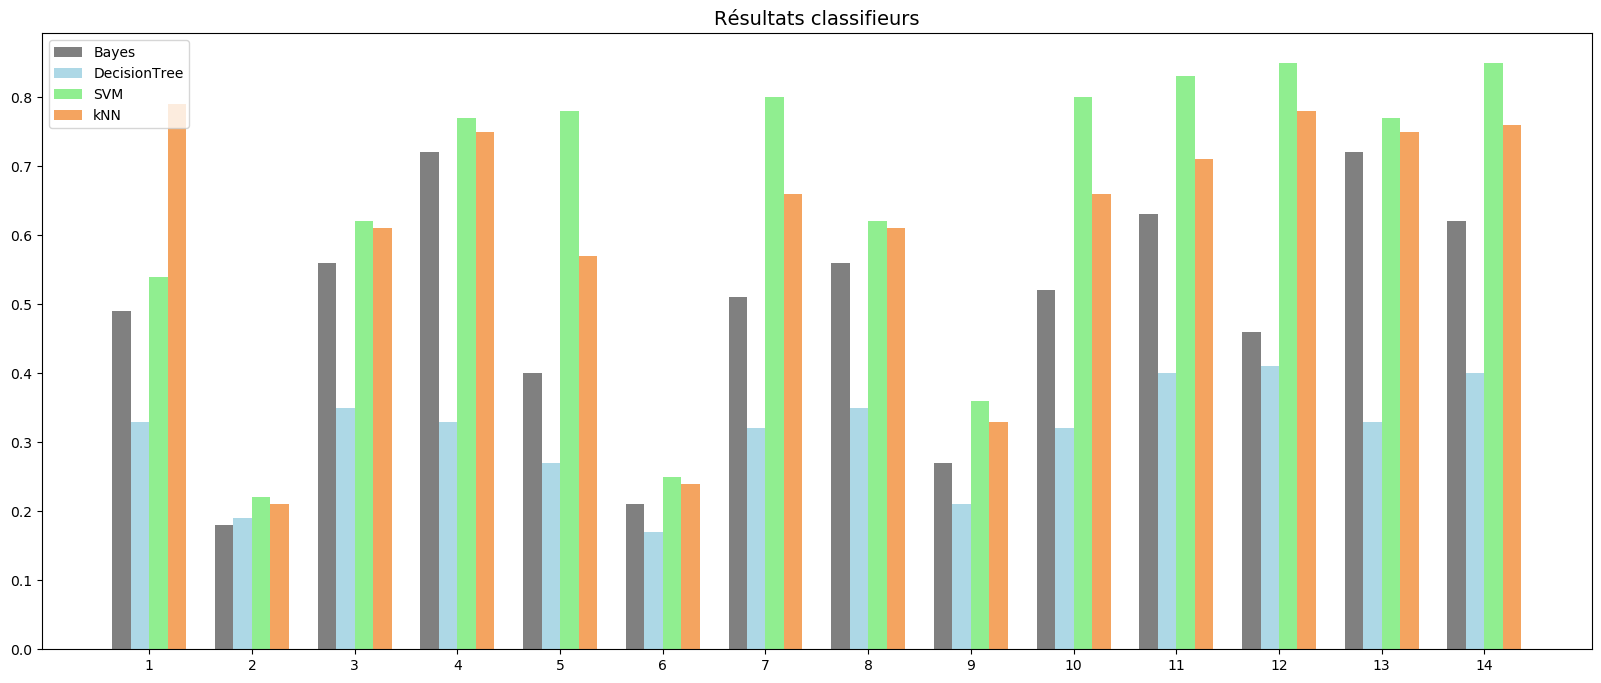

In [113]:
fig, ax = plt.subplots(figsize=(20, 8))

x = np.arange(1, nb_iterations+1)
bar_width = 0.18

for i in x:
    
    bar1 = ax.bar(i-(1.5*bar_width),
                 df_score.loc[df_score["iteration"] == i, "bayes"],
                 width=bar_width,
                  color="gray"
                )
    bar2 = ax.bar(i-bar_width/2,
                 df_score.loc[df_score["iteration"] == i, "tree"],
                 width=bar_width,
                  color="lightblue"
                )
    bar3 = ax.bar(i+bar_width/2,
                 df_score.loc[df_score["iteration"] == i, "svm"],
                 width=bar_width,
                  color="lightgreen"
                )
    bar4 = ax.bar(i+(1.5*bar_width),
                 df_score.loc[df_score["iteration"] == i, "knn"],
                 width=bar_width,
                  color="sandybrown"
                )

# Fix the x-axes.
ax.set_xticks(x)
ax.set_xticklabels(x)

plt.legend(["Bayes", "DecisionTree", "SVM", "kNN"], loc="upper left")
plt.title("Résultats classifieurs", size=14)

In [114]:
y_test.unique()

array(['Kitchen & Dining ', 'Baby Care ', 'Home Furnishing ',
       'Home Decor & Festive Needs ', 'Watches ',
       'Beauty and Personal Care ', 'Computers '], dtype=object)

In [115]:
lst_cat = y_test.unique()

y_test.value_counts()

Baby Care                      42
Home Furnishing                40
Beauty and Personal Care       40
Watches                        39
Computers                      36
Kitchen & Dining               34
Home Decor & Festive Needs     32
Name: sous_cat_1, dtype: int64

L'echantillon de test contient : 263 articles.
Wall time: 94.5 ms


(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

<Figure size 1000x1000 with 0 Axes>

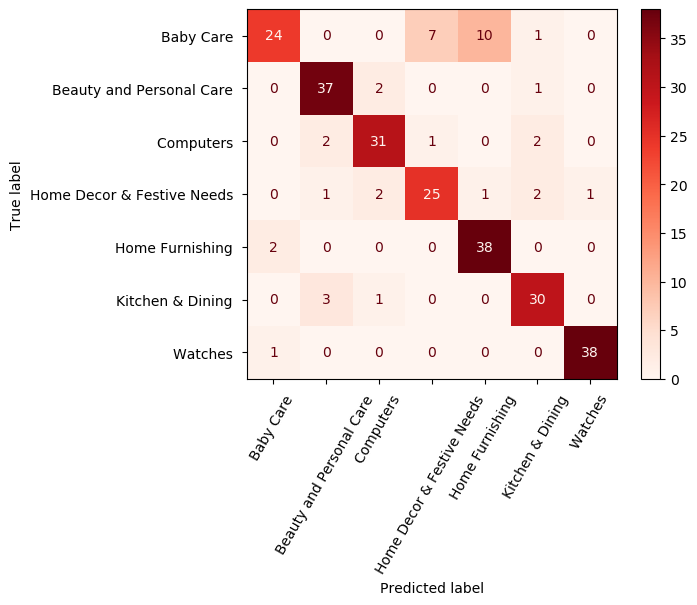

In [116]:
%%time

from sklearn.metrics import plot_confusion_matrix

# creating a confusion matrix 
cm = confusion_matrix(y_test, svm_predictions)

plt.figure(figsize=(10,10))

print("L'echantillon de test contient :", X_test.shape[0], "articles.")

disp = plot_confusion_matrix(svm_model_linear,
                             X_test, 
                             y_test,
                             cmap="Reds")


plt.xticks(rotation=60)
#disp.yaxis.set_ticklabels(disp.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)
#disp.xaxis.set_ticklabels(disp.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)
#plt.ylabel("Catégories", size=12)
#plt.xlabel("Clusters", size=12)

# Clustering

### K-means

Nous allons rechercher la meilleure itération pour le K-means

In [117]:
def kmeans(mydata):

    #Cette fonction permet de calculer le nombre de clusters le plus optimal pour notre analyse : le coefficient de silhouette

    silhouette = []
    dispersion = []

    result_clusters = []
    result_ninit = []
    result_type_init = []

    df_iter_kmeans = pd.DataFrame()

    n_clusters = range(5,10)
    nbr_init = [10,30,50,70]
    type_init = ["k-means++", "random"]

    #Nous allons tester le modèle entre 2 et 15 clusters
    for num_clusters in n_clusters:

        for init in nbr_init:

            for i in type_init:

                #On configure l'algorithme
                cls = MiniBatchKMeans(n_clusters=num_clusters, 
                                     n_init=init, 
                                     init=i,
                                     random_state=0
                                    )

                #On l'entraîne sur les données préparées
                cls.fit(mydata)

                #On enregistre les scores de coefficient de silhouette à chaque passage
                silh = metrics.silhouette_score(mydata, cls.labels_)
                disp = cls.inertia_

                silhouette.append(silh)
                dispersion.append(disp)
                result_clusters.append(num_clusters)
                result_ninit.append(init)
                result_type_init.append(i)

    df_iter_kmeans["coef_silh"] = silhouette
    df_iter_kmeans["dispersion"] = dispersion
    df_iter_kmeans["nbr_clusters"] = result_clusters
    df_iter_kmeans["n_init"] = result_ninit
    df_iter_kmeans["type_init"] = result_type_init
    
    return df_iter_kmeans

In [118]:
def recherche_best_iter(mydata):

    #On affiche les paramètres de la meilleure itération
    best_iter = mydata.where(mydata["coef_silh"] == mydata["coef_silh"].max())
    best_iter.dropna(how="any", inplace=True)
    
    #On traite le cas où il y a plusieurs solutions possibles
    if best_iter.shape[0] > 0:
        best_iter = best_iter.iloc[0, :]
        
    # print(best_iter)

    return best_iter

In [119]:
def best_kmeans(mydata, best, cat_true):
    
    #On fait retourner le K-means avec la meilleure itération vue précédemment
    #Nous forçons le nombre de lusters à 7
    nbr_clusters = 7  # int(best["nbr_clusters"])
    ninit = int(best["n_init"])
    type_init = best["type_init"]

    cls_kmeans = MiniBatchKMeans(n_clusters=nbr_clusters, 
                                     n_init=ninit, 
                                     init=type_init,
                                     random_state=0
                                    )

    #On l'entraîne sur les données préparées
    cls_kmeans.fit(mydata)

    df_kmeans = pd.DataFrame()
    df_kmeans["labels"] = cls_kmeans.labels_
    df_kmeans["nbr_individus"] = 0
    df_kmeans = df_kmeans.groupby("labels", as_index=False).count()
    
    silh = round(metrics.silhouette_score(mydata, cls_kmeans.labels_), 2)
    ari = round(metrics.adjusted_rand_score(cat_true, cls_kmeans.labels_), 2)
    
    print("Coef silhouette :", silh)
    print("Score Adjusted Rand index :", ari)
    return cls_kmeans.labels_, df_kmeans, silh, ari;

In [120]:
def results_iterations_kmeans(mydata):

    #On affiche les scores

    df_coef_silh = mydata.groupby("nbr_clusters", as_index=False)["coef_silh"].max()
    df_dispersion = mydata.groupby("nbr_clusters", as_index=False)["dispersion"].min()

    plt.subplots(figsize=(25,10))

    plt.subplot(1,2,1)

    plt.plot(df_coef_silh["nbr_clusters"], df_coef_silh["coef_silh"], marker="o")
    plt.xlabel("Nbr de clusters", size=14)
    plt.ylabel("Coefficient de silhouette", size=14)
    plt.title("Variation coefficient de silhouette", size=14)
    plt.grid()

    plt.subplot(1,2,2)

    plt.plot(df_dispersion["nbr_clusters"], df_dispersion["dispersion"], marker="o")
    plt.xlabel("Nbr de clusters", size=14)
    plt.ylabel("Compacité clusters", size=14)
    plt.title("Variation de la compacité des clusters", size=14)
    plt.grid()


In [121]:
def homogeneite_clusters(mydata):

    print(mydata)
    plt.figure(figsize=(10,10))

    plt.bar(mydata["labels"], height=mydata["nbr_individus"])
    plt.xlabel("Nbr de clusters", size=14)
    plt.ylabel("Nbr individus", size=14)
    plt.title("Classement des individus", size=14)

In [122]:
def affich_tsne(mydata):
                
    time_start= time.time()

    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    
    tsne_results = tsne.fit_transform(mydata)
    
    print("TSNE terminée. Temps écoulé {} seconds.".format(time.time() - time_start))

    df_results = pd.DataFrame(tsne_results, columns=["tsne_2d_one", "tsne_2d_two"])
    
    #df_results["labels"] = labels #cls_kmeans.labels_
        
    plt.figure(figsize=(25,12))
    
    sns.scatterplot(
        x=df_results["tsne_2d_one"],
        y=df_results["tsne_2d_two"],
        hue=mydata["labels"],
        palette=sns.color_palette("hls", n_colors = len(mydata["labels"].unique())),
        data=df_results,
        legend="full",
        #alpha=0.3
    )
    

In [123]:
%%time
from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

import time

lst_iterations = [df_iter_texte,
                  df_word2vec,
                  df_iter_bovw,
                  df_iter_vgg16,
                  df_iter_resnet50,
                  df_iter1_nmf,
                  df_iter2_nmf,
                  df_iter3_pca,
                  df_iter4_pca,
                  df_iter5,
                  df_iter6_nmf,
                  df_iter7
                 ]

lst_desc_iter = ["txt-tfidf",
                "txt_word2vec",
                "img_bovw",
                "img_vgg16",
                "img_resnet50",
                "nmf : txt_tfidf | img_bovw",
                "nmf : txt_tfidf | img_VGG16",
                "pca : txt_word2vec | img_bovw",
                "pca : txt_word2vec | img_VGG16",
                "txt_word2vec | img_VGG16_nmf",
                "nmf : txt_tfidf | img_ResNet50",
                "txt_word2vec | img_ResNet50_nmf"
                ]

le = LabelEncoder()
df_train["cat_encodee"] = le.fit_transform(df_train["sous_cat_1"])

# On va lancer l'algorithme pour chaque itération
# puis comparer leur scores : Coeff silhouette + ARI
# en les enregistrant dans un nouveau dataframe

df_scores = pd.DataFrame(columns=["iteration", "silhouette", "ari"], index=range(0, len(lst_iterations)))

j = 0

for i in lst_iterations:

    print("---------------------------------------------")
    print("Traitement de l'itération :", lst_desc_iter[j])
    
    #On fait un gridsearch sur le kmeans
    print("Recherche meilleur paramétrage sur GridSearch")
    df_iter_kmeans = kmeans(i)

    #Affichage des résultats des itérations
    #results_iterations_kmeans(df_iter_kmeans)

    #On recherche la meilleure itération
    print("Sélection meilleure itération")
    df_best_kmeans = recherche_best_iter(df_iter_kmeans)

    #On refait tourner l'algorithme du Kmeans avec la meilleure itération
    print("Kmeans en cours avec les meilleurs hyperparamètres et un nombre de clusters = 7")
    kmeans_labels, results, silhouette, ari = best_kmeans(i, df_best_kmeans, df_train["cat_encodee"])
    
    i["labels"] = kmeans_labels
    df_results_kmeans = results
    
    df_scores["iteration"][j] = lst_desc_iter[j]
    df_scores["silhouette"][j] = silhouette
    df_scores["ari"][j] = ari

    j += 1


---------------------------------------------
Traitement de l'itération : txt-tfidf
Recherche meilleur paramétrage sur GridSearch
Sélection meilleure itération
Kmeans en cours avec les meilleurs hyperparamètres et un nombre de clusters = 7
Coef silhouette : 0.54
Score Adjusted Rand index : 0.13
---------------------------------------------
Traitement de l'itération : txt_word2vec
Recherche meilleur paramétrage sur GridSearch
Sélection meilleure itération
Kmeans en cours avec les meilleurs hyperparamètres et un nombre de clusters = 7
Coef silhouette : 0.36
Score Adjusted Rand index : 0.23
---------------------------------------------
Traitement de l'itération : img_bovw
Recherche meilleur paramétrage sur GridSearch
Sélection meilleure itération
Kmeans en cours avec les meilleurs hyperparamètres et un nombre de clusters = 7
Coef silhouette : 0.34
Score Adjusted Rand index : 0.02
---------------------------------------------
Traitement de l'itération : img_vgg16
Recherche meilleur paramét

# Analyse des résultats

Une fois que toutes nos itérations ont été clusterisées, nous allons étudier les résultats :
 1. Synthèse des scores :
     - Classement des coefficients de silhouette
     - Classement des ARI
     - Choix de la meilleure itération sur l'ARI
     
 2. Etude de la meilleure itération :
     - Analyse TSNE
     - Analyse homogénéïté des clusters
     - Comparaison des clusters en fonction des catégories de départ. Avec une matrice de confusion.

### Etude globale et synthèse

In [124]:
df_scores

iteration silhouette   ari
0                         txt-tfidf       0.54  0.13
1                      txt_word2vec       0.36  0.23
2                          img_bovw       0.34  0.02
3                         img_vgg16       0.41  0.18
4                      img_resnet50        0.4  0.36
5        nmf : txt_tfidf | img_bovw       0.32  0.02
6       nmf : txt_tfidf | img_VGG16       0.41  0.18
7     pca : txt_word2vec | img_bovw       0.05  0.03
8    pca : txt_word2vec | img_VGG16       0.04  0.12
9      txt_word2vec | img_VGG16_nmf       0.38   0.2
10   nmf : txt_tfidf | img_ResNet50        0.4  0.37
11  txt_word2vec | img_ResNet50_nmf       0.36  0.37

Text(0.5, 1.0, 'Comparaison coefficients de silhouette')

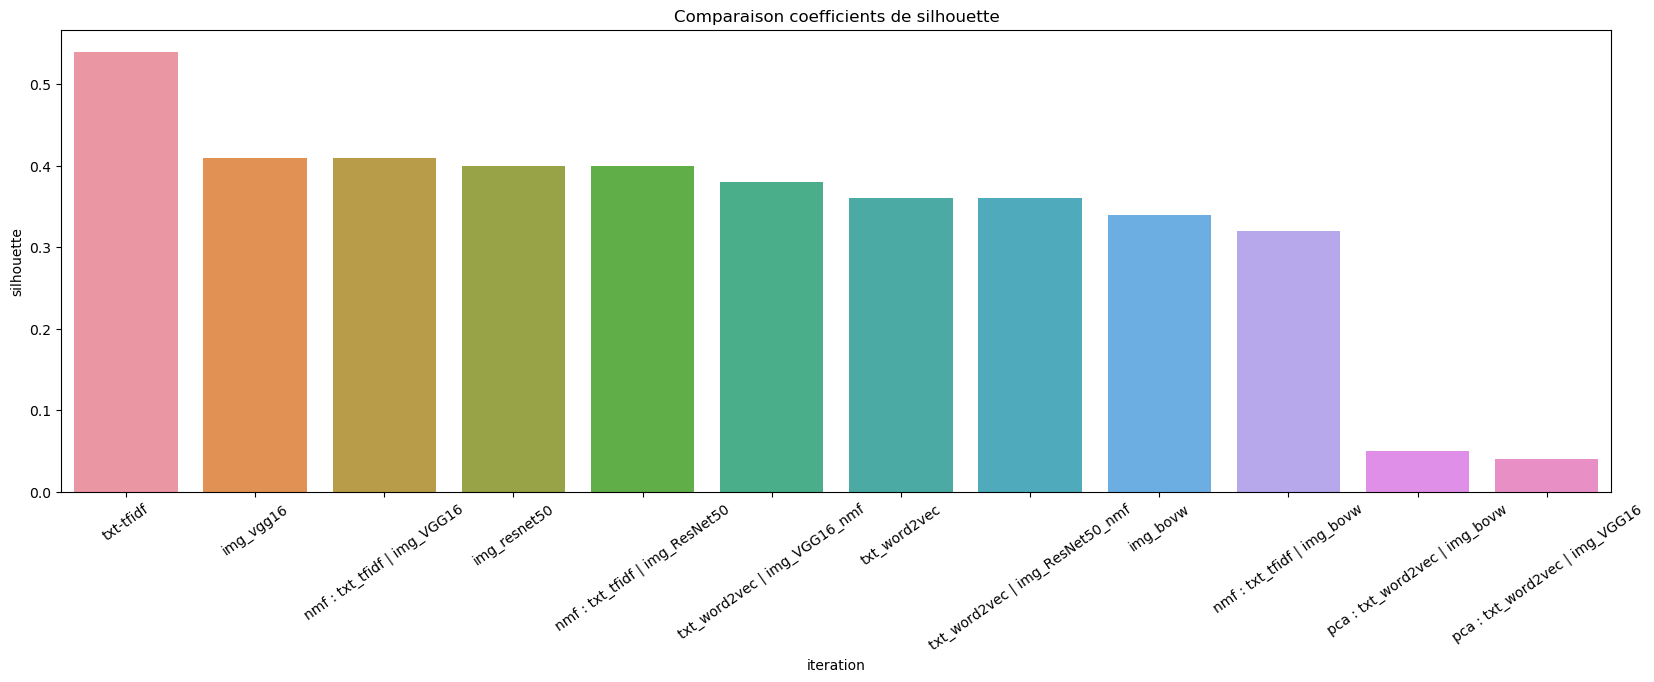

In [125]:

data = df_scores.sort_values(by="silhouette", ascending=False)
plt.figure(figsize=(20, 6))
plt.xticks(rotation=35)
sns.barplot(x=data["iteration"], y=data["silhouette"])
plt.title("Comparaison coefficients de silhouette", size=12)

Text(0.5, 1.0, 'Comparaison des Adjusted Rand Index')

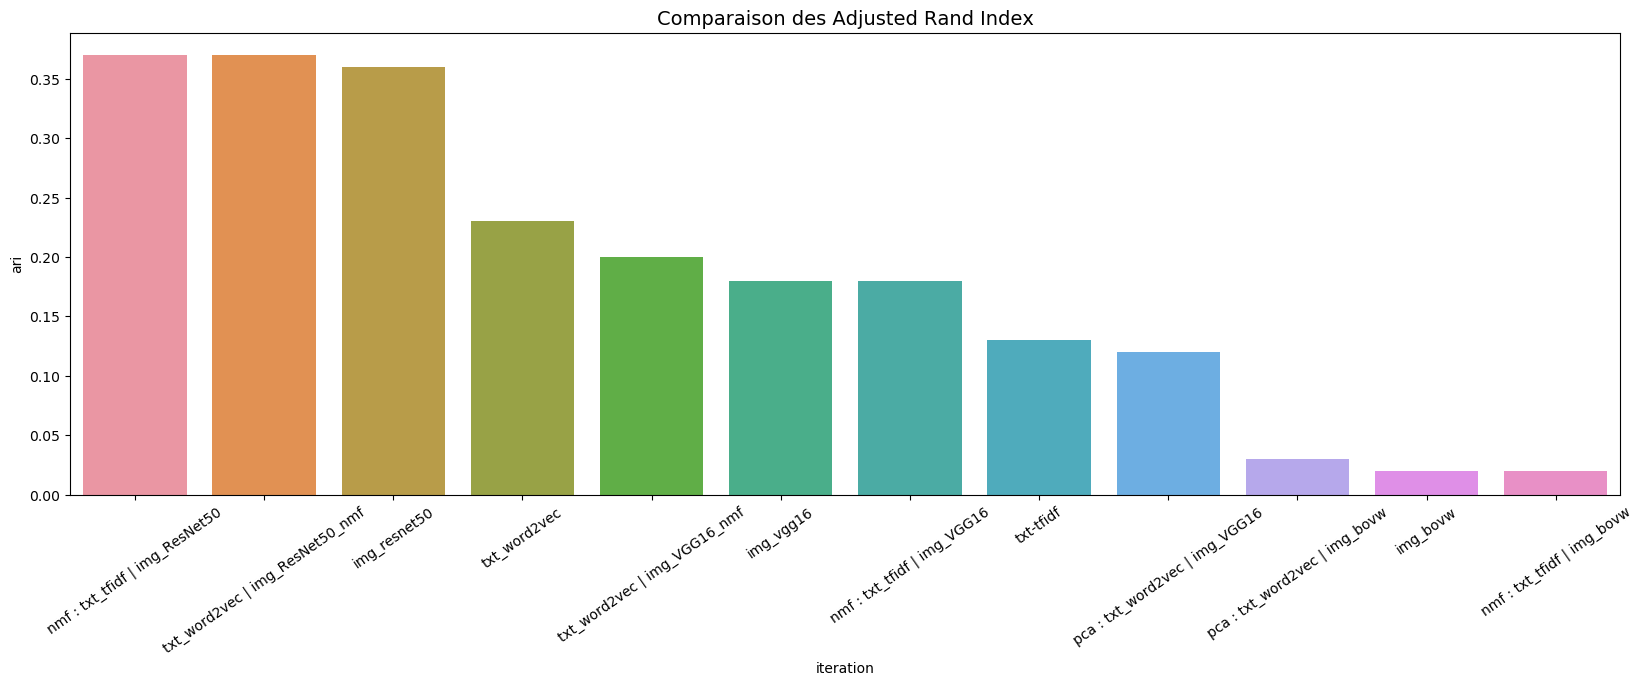

In [126]:

data = df_scores.sort_values(by="ari", ascending=False)
plt.figure(figsize=(20, 6))
plt.xticks(rotation=35)
sns.barplot(x=data["iteration"], y=data["ari"])
plt.title("Comparaison des Adjusted Rand Index", size=14)

### Etude meilleure itération

#### TSNE

TSNE - Kmeans
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.002s...
[t-SNE] Computed neighbors for 1050 samples in 0.034s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 0.817447
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.387753
[t-SNE] KL divergence after 300 iterations: 0.492935
TSNE terminée. Temps écoulé 0.8901538848876953 seconds.


<Figure size 2000x600 with 0 Axes>

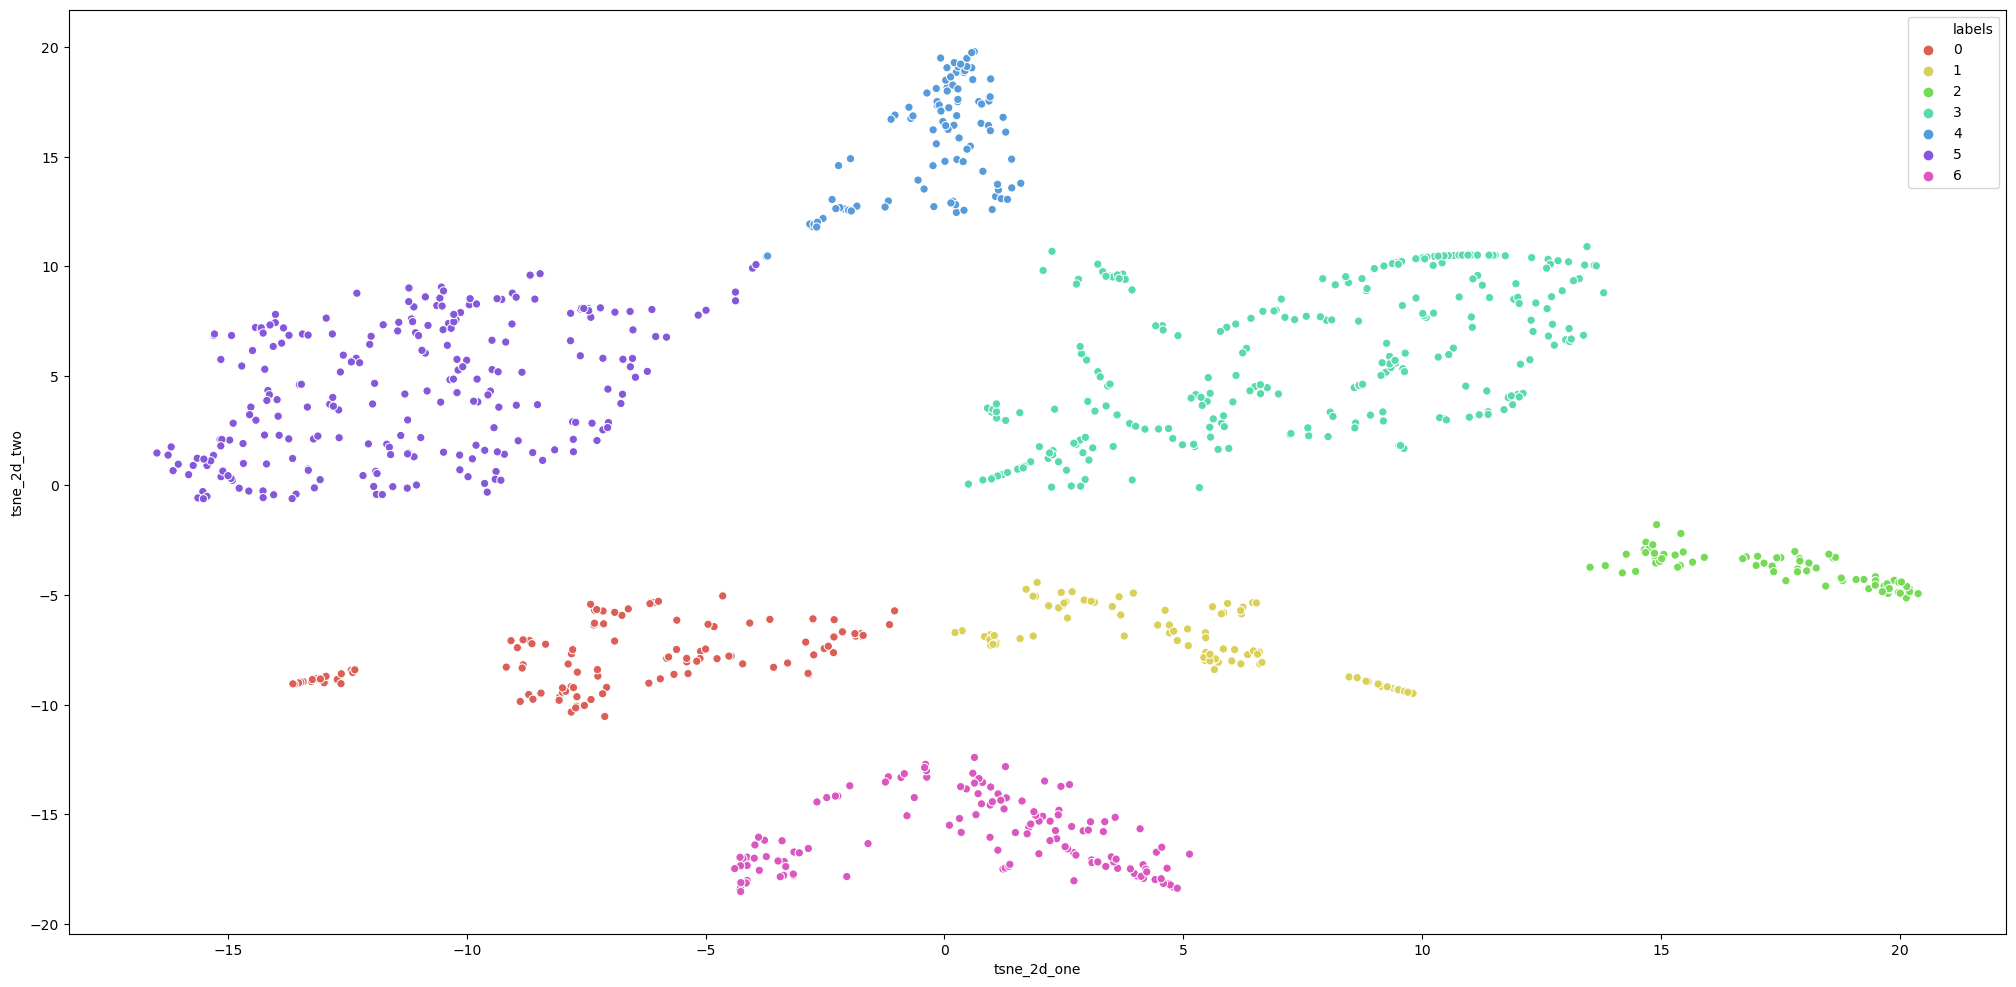

In [127]:

# On affiche l'aspect de l'homogénéité des clusters
# print("Homogénéité clusters")
# homogeneite_clusters(df_results_kmeans)

# On affiche la TSNE
print("TSNE - Kmeans")
plt.figure(figsize=(20,6))
affich_tsne(df_iter6_nmf)

#### Homogénéïté clusters

In [128]:
df_nb_individus = pd.DataFrame(df_iter6_nmf["labels"].value_counts(), columns=["labels", "nbr_individus"])
df_nb_individus["nbr_individus"] = df_nb_individus["labels"]
df_nb_individus.drop("labels", axis=1, inplace=True)
df_nb_individus.reset_index(inplace=True)
df_nb_individus = df_nb_individus.rename(columns={"index": "labels"})
df_nb_individus

labels  nbr_individus
0       3            263
1       5            237
2       6            141
3       0            131
4       4            103
5       1             98
6       2             77

Homogénéité clusters
   labels  nbr_individus
0       3            263
1       5            237
2       6            141
3       0            131
4       4            103
5       1             98
6       2             77


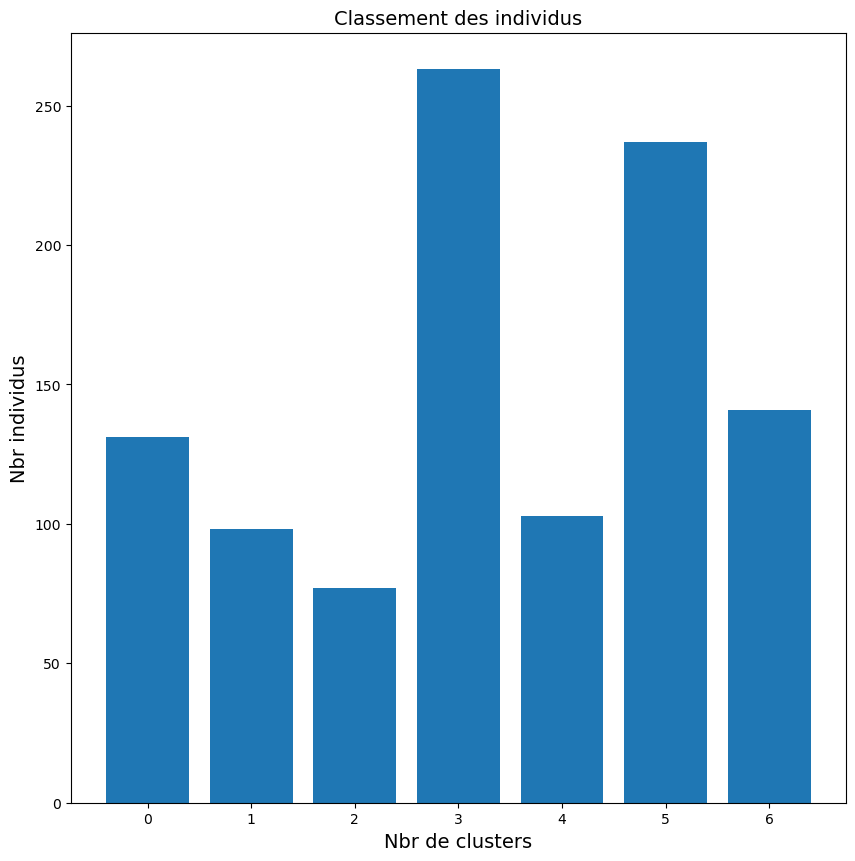

In [129]:
# On affiche l'aspect de l'homogénéité des clusters
print("Homogénéité clusters")
homogeneite_clusters(df_nb_individus)


#### Matrice de confusion

Text(0.5, 80.7222222222222, 'Clusters')

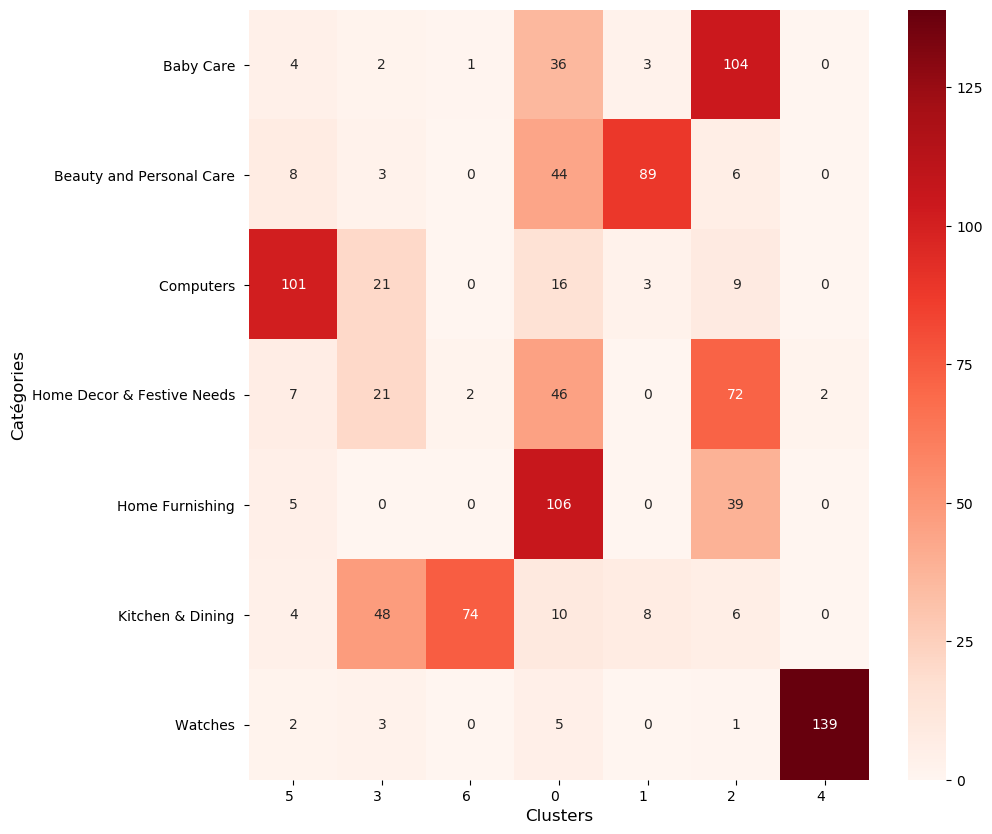

In [130]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(df_train["cat_encodee"], df_iter6_nmf["labels"])

df_tri_cat = df_train.sort_values(by="cat_encodee")

df_cm = pd.DataFrame(cm, 
                     index=df_tri_cat["sous_cat_1"].unique(), 
                     columns=df_iter6_nmf["labels"].unique()
                    )

fig = plt.figure(figsize=(10,10))

try:
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="Reds")
except ValueError:
    raise ValueError("Confusion matrix values must be integers.")
    
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)
plt.ylabel("Catégories", size=12)
plt.xlabel("Clusters", size=12)

In [131]:
param_dist = {'C': [0.001, 0.01, 0.1, 1, 10]}
random_search = RandomizedSearchCV(LogisticRegression(),
                            param_distributions=param_dist,
                            cv=10,
                            iid=False)

df_train_vect = df_iter6_nmf.drop("labels", axis=1)
df_target = df_iter6_nmf["labels"]
rand_search_iter6 = random_search.fit(df_iter6_nmf, des_target)

print("Mean Random Search accuracy:", rand_search_iter6.best_score_)

C:\Users\julie\Anaconda\envs\Projet 6-2\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
C:\Users\julie\Anaconda\envs\Projet 6-2\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\julie\Anaconda\envs\Projet 6-2\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTA

Mean Random Search accuracy: 0.7304761904761905


C:\Users\julie\Anaconda\envs\Projet 6-2\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\julie\Anaconda\envs\Projet 6-2\lib\site-packages\sklearn\model_selection\_search.py:825: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
C:\Users\julie\Anaconda\envs\Projet 6-2\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations

In [132]:
from sklearn.neighbors import KNeighborsClassifier

#create new a knn model
knn = KNeighborsClassifier()

#create a dictionary of all values we want to test for n_neighbors
param_grid = {"n_neighbors": np.arange(1, 11)}

#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn, param_grid, cv=10)

#fit model to data
knn_gscv.fit(df_train_vect, df_target)
    
#check top performing n_neighbors value
print("La meilleure accuracy est",
      knn_gscv.score(df_train_vect, df_target),
      "avec",
      knn_gscv.best_params_,
      "voisins.")

La meilleure accuracy est 0.9628571428571429 avec {'n_neighbors': 9} voisins.


# API Amazon

Il nous ait proposé d'utiliser l'API d'Amazon pour enrichir notre jeu de données afin d'améliorer les performances du modèle. Cependant l'API Amazon n'est disponible que pour les partenaire d'Amazon ce qui n'est pas notre cas. Nous allons donc expliquer le fonctionnement de l'API, et écrire la requête permettant de se servir de l'API.

La première étape est de s'inscrire sur le site d'AWS en tant que partenaire d'Amazon, et de remplir les différentes informations sur notre boutique et les produits que l'on vend.

Ensuite, nous devons identifier la fonction de base que nous allons utiliser. Quelques exemples :
 - ItemSearch – recherche d’un article spécifique ou d’un groupe d’articles en fonction de paramètres comme la catégorie, le fabricant, le titre, le prix minimum, etc. Cette fonction peut donner un ou plusieurs résultats
 - ItemLookup – Recherche d’un article spécifique à l’aide d’un identifiant comme l’ISBN (pour les livres) ou l’ASIN (ASIN Amazon Standard Identification Number, code unique attribué à tous les produits de son catalogue). Cette fonction ne donne qu’un résultat
 - SimilarityLookup – Recherche d’articles similaires à celui mentionné dans la requête API
 - CartCreate – Création d’un panier virtuel sur Amazon
 - CartAdd – Ajouter des articles spécifiques au panier virtuel.

Voici la requête de sortie une fois que l'on a codé celle-ci :
<i><br>
https://webservices.amazon.com/onca/xml?<br>
AWSAccessKeyId={Your Access Key}&<br>
AssociateTag=letthereblight-20&<br>
Keywords=60w%20Edison%20ST58&<br>
Operation=ItemSearch&<br>
ResponseGroup=Large&<br>
SearchIndex=Tools&<br>
Service=AWSECommerceService&<br>
Timestamp={Call Time Stamp}&<br>
Signature={Generated Signature}<br>
</i>

Et les explications des différents paramètres :
<i><br>
https://webservices.amazon.com/onca/xml — this is the API endpoint, it is different between amazon.com or amazon.uk and allow you to search in a specific store<br>
AWSAccessKeyId — and access key you generate to call and sign your request<br>
AssociateTag — a tag representing your site with Amazon. You have to use it if you wish to get paid by Amazon. Users that will get to Amazon with this tag will be set as users coming from your website/app<br>
Keywords — the keywords you were looking for, in this case, you were looking for a product similar to 60w Edison ST58<br>
Operation — you are stating you wish to search for product (there are other operation as well — not going to be discussed here)<br>
ResponseGroup — amount of details you wish to get back about the products. Large tells Amazon to include all data it has. You should consider what you actually need to optimize call time\bandwidth etc.<br>
SearchIndex — the category to search within (light bulbs are part of tools so we use that in our case). This, again, will filter unneeded results and will save time \ bandwidth. In our case, we wish to avoid light bulbs related to auto parts<br>
Service — kind of the same for all calls. you are indicating you are using Amazon Prodcut API here<br>
Timestamp — the time you initiated the call to the API. It will make sure your call is “fresh”<br>
Signature — this is the hash key you get when you sign your request for the API. It is used to validate the call and it is related to the request signing process<br>
</i>

<b>Response Elements :</b>

The following are common elements that are returned.<br><br>
<i>
Name	Description<br>
Item	Container for item information, including ASIN, DetailPageURL, ItemLinks, and ItemAttributes.<br>
ASIN	Amazon Standard Identification Number, which is an alphanumeric token assigned by Amazon to an item.<br>
DetailPageURL	The URL to the item detail page on Amazon.<br>
ItemLinks	Container for URLs, including Add To Wedding Registry, Add To Wishlist, All Customer Reviews, and All Offers.<br>
ItemAttributes	Container for information about an item, including brand, manufacturer, product group, and title.<br>
MoreSearchResultsURL	The URL that displays the complete search results. Use these URLs to link back to the item on Amazon. Each URL is tagged with your Associate tag and contains tracking information to increase your hourly request limit as the sales you generate increase.<br>
TotalPages	Total number of pages in the response. Each page can return up to ten items.<br>
TotalResults	Total number of items found.<br>
</i>

In [133]:
from amazon.api import AmazonAPI

# AMAZON_ACCESS_KEY -> Clé d'accès
# AMAZON_SECRET_KEY -> Clé secrète
# AMAZON_ASSOC_TAG -> ID partenaire
amazon = AmazonAPI(AMAZON_ACCESS_KEY, 
                   AMAZON_SECRET_KEY, 
                   AMAZON_ASSOC_TAG
                  )

products = amazon.search_n(1000, 
                           Keywords="Computers" 
                           SearchIndex="All")

SyntaxError: invalid syntax (<ipython-input-133-741cb901ddaf>, line 13)